In [ ]:
# Import necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances, adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import kmedoids

# Custom helper functions
from helper import (plot_dbscan_grid, simulate_clean_dataset, visualize_kmeans_steps, 
                   plot_kmeans_clusters, plot_silhouette_scores, plot_elbow_method, 
                   simulate_dataset_with_outliers, compare_kmeans_kmedoids, 
                   plot_hierarchical_clustering, generate_non_spherical_data, 
                   plot_k_distance_graph, plot_clustering_comparison, 
                   gene_info, compare_all_Algorithms, plot_2cluster_comparison)

warnings.filterwarnings('ignore')


# Notes

- TODO: Maybe add the K-Distance graph to figure out good values? DBSCAN -> breast cancer ds
- We should also show how to deal with mixed (including also categorical data) when doing clustering -> where?


<br><br>
# **Table of Contents**
- [Notes](#notes)
- [Hands-On: Clustering](#hands-on-clustering)
  - [Introduction to the Wine Dataset](#introduction-to-the-wine-dataset)
- [K-Means/K-Medoids Clustering](#k-meansk-medoids-clustering)
  - [From K-Means to K-Medoids](#from-k-means-to-k-medoids)
  - [K-Means vs K-Medoids: Comparison](#k-means-vs-k-medoids-comparison)
- [Hierarchical Clustering](#hierarchical-clustering)
  - [Ward's Method](#wards-method)
  - [How to Read Dendrograms](#how-to-read-dendrograms)
  - [Single Linkage Method](#single-linkage-method)
  - [Complete Linkage Method](#complete-linkage-method)
  - [Average Linkage Method](#average-linkage-method)
  - [Hierarchical Clustering Overview](#hierarchical-clustering-overview)
- [Density-Based Spatial Clustering of Applications with Noise (DBSCAN) Clustering](#density-based-spatial-clustering-of-applications-with-noise-dbscan-clustering)
  - [Understanding the K-Distance Graph](#understanding-the-k-distance-graph)
  - [DBSCAN Parameter Effects](#dbscan-parameter-effects)
- [Clustering Methods Overview](#clustering-methods-overview)
- [Applying Clustering to Medical Data](#applying-clustering-to-medical-data)
  - [Recap Breast Cancer Wisconsin Dataset](#recap-breast-cancer-wisconsin-dataset)
  - [K-Means / K-Medoids](#k-means--k-medoids)
  - [Hierarchical Clustering](#hierarchical-clustering-1)
  - [DBSCAN](#dbscan)
  - [Overview](#overview)

<br><br>
# **Hands-On: Clustering**

## Learning Goals
By the end of this session, you will be able to:

- **Implement partitioning clustering algorithms**
  - Apply K-Means and K-Medoids clustering to discover natural groups in datasets
  - Compare centroid-based vs. medoid-based approaches and understand when to use each method

- **Master hierarchical clustering techniques**
  - Use Ward's, single, complete, and average linkage methods to build cluster hierarchies
  - Read and interpret dendrograms to determine optimal cluster numbers and relationships

- **Apply density-based clustering methods**
  - Implement DBSCAN to identify clusters of varying shapes and detect outliers
  - Tune parameters using K-distance graphs and understand effects on cluster formation

<br><br>
# **K-Means/K-Medoids Clustering**

**K-Means Clustering** is a simple and popular approach for partitioning a dataset into *K* distinct, non-overlapping clusters. It's one of the most widely used unsupervised learning algorithms in data science.

## Key Characteristics
- **Must specify K beforehand** - You need to decide how many clusters to find
- **Centroid-based** - Each cluster is represented by its center point (centroid)
- **Iterative algorithm** - Repeats steps until convergence
- **Goal** - Minimize the within-cluster variation and maximize the between-cluster variation
- **Assumes spherical clusters** - Works best when clusters are roughly round and similar sizes
- **Sensitive to outliers** - Extreme values can significantly affect cluster centers

## Dataset for Demonstration

To understand how K-Means works, we'll create a **simulated 2D dataset** with known cluster structure. We'll generate 300 data points distributed across 4 natural clusters, then demonstrate how to discover this structure using clustering algorithms. Feel free to adjust the parameters to experiment!


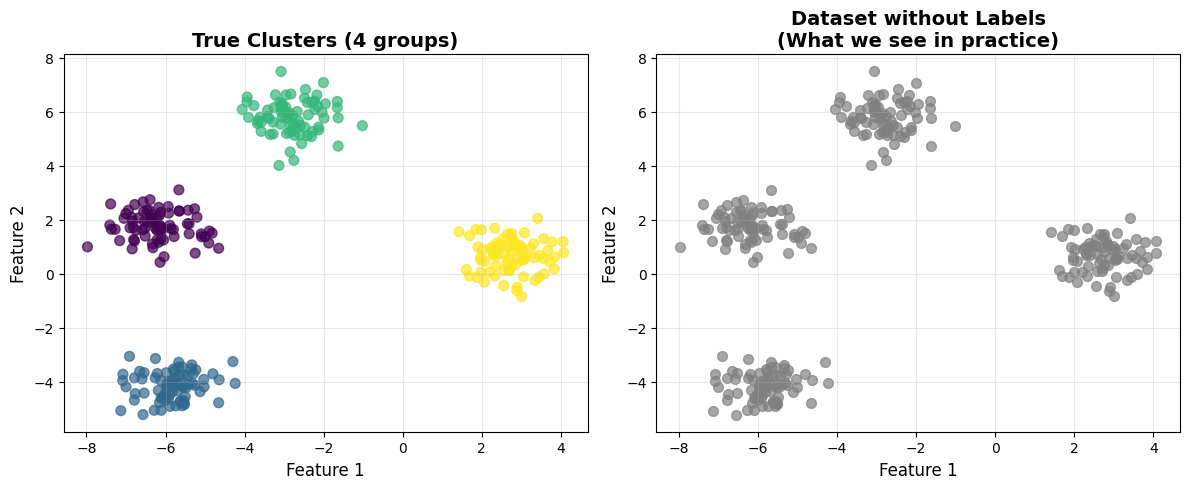

In [2]:
X_clean, y_true = simulate_clean_dataset()

Now let's see how K-Means works in practice!

## How K-Means Works:

**Step 1: Initialize**
- Choose *K* random starting points as initial cluster centroids
- Common methods: random points, K-means++ (smarter initialization)

**Step 2: Assignment**
- For each data point, calculate distance to all centroids
- Assign each point to the closest centroid's cluster

**Step 3: Update**
- Calculate the mean (centroid) of all points in each cluster
- Move the centroid to this new mean position

**Step 4: Repeat**
- Repeat steps 2-3 until convergence:
  - Centroids stop moving significantly, OR
  - Cluster assignments stop changing, OR
  - Maximum iterations reached

Let's see how well K-Means performs on our dataset and visualize the clustering process step by step!

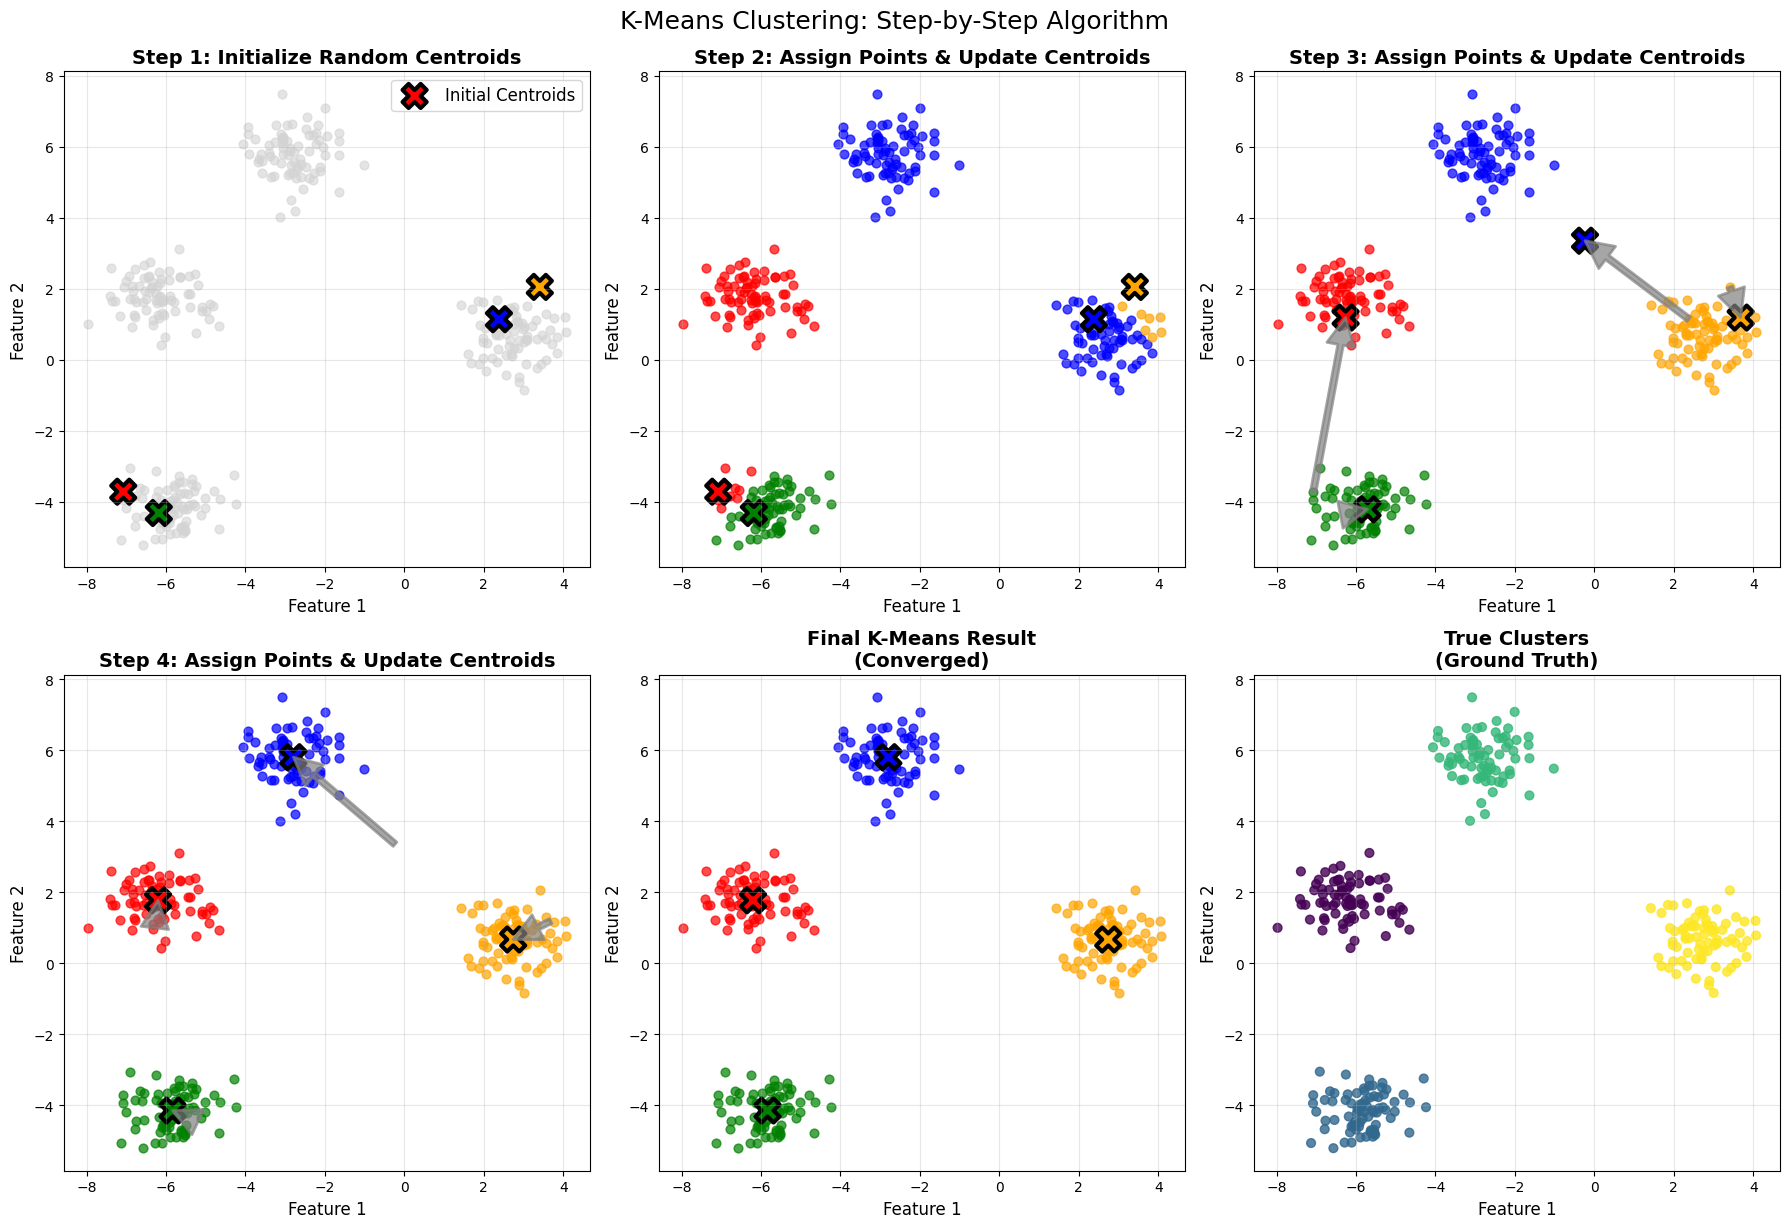

In [3]:
visualize_kmeans_steps(X_clean, y_true)

### Key Observations

**Excellent Performance:**
- **Perfect clustering**: Successfully identified all 4 natural clusters
- **Fast convergence**: Stabilized in just 3-4 iterations
- **Accurate results**: Final clusters match ground truth perfectly

**Why K-Means Worked Well:**
- Well-separated, spherical clusters of similar sizes
- No outliers to distort the centroids
- Clean data matching K-means assumptions

Let's use KMeans now with the `Scikit-learn` package!

In [4]:
# Apply K-Means with k=4 (from elbow method)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_clean)
kmeans_centroids = kmeans.cluster_centers_

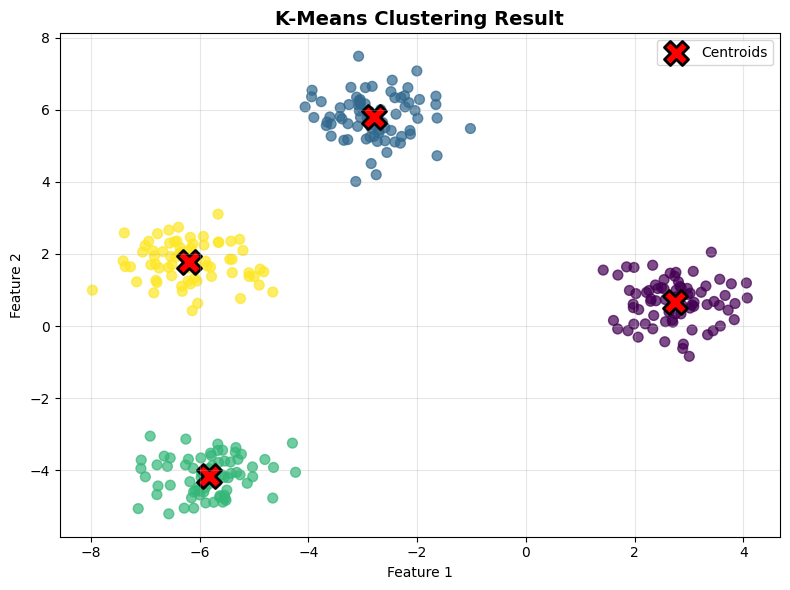

In [5]:
plot_kmeans_clusters(X_clean, kmeans_labels, kmeans_centroids)

## Measuring Cluster Quality with silhouette score

The **silhouette score** measures how well each point fits in its assigned cluster compared to other clusters. It ranges from -1 to 1:
- **Close to 1**: Point is well-matched to its cluster and far from others
- **Close to 0**: Point is on the border between clusters  
- **Negative**: Point might be in the wrong cluster

Let's visualize the silhouette scores for our K-means result:

In [6]:
# Calculate silhouette scores
silhouette_scores = silhouette_score(X_clean, kmeans_labels)
sample_silhouette_values = silhouette_samples(X_clean, kmeans_labels)

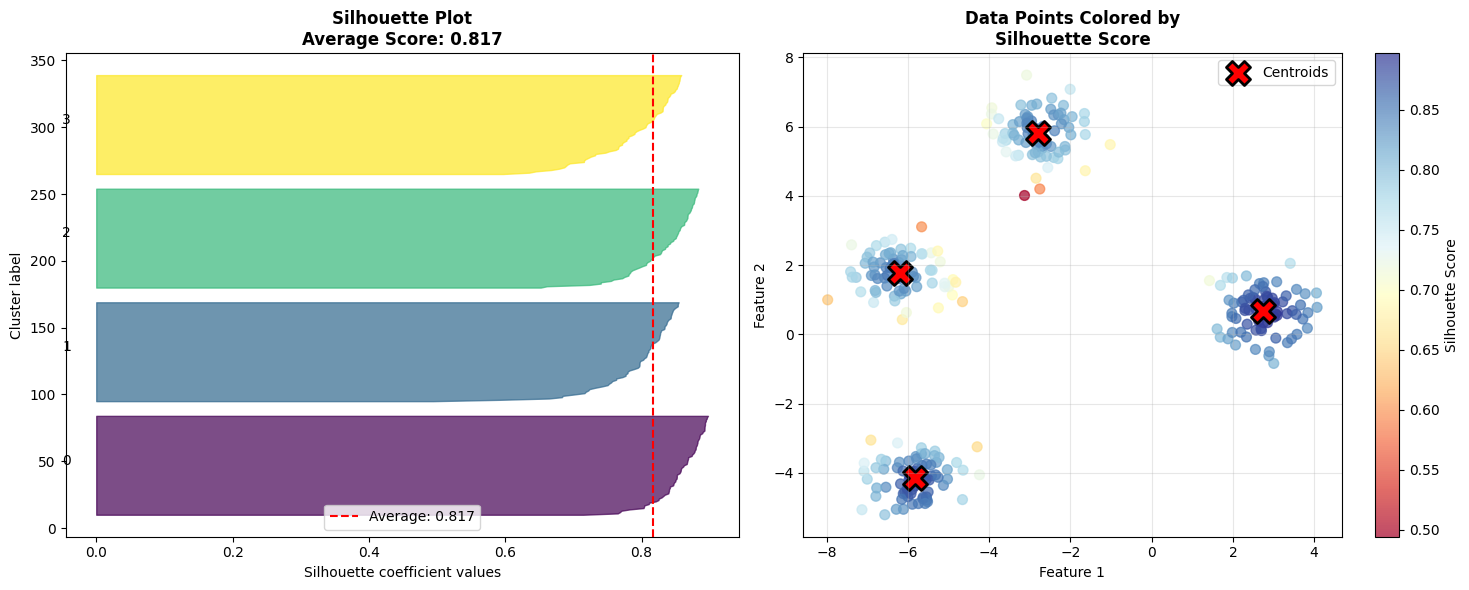

In [7]:
plot_silhouette_scores(X_clean, kmeans_labels, kmeans_centroids, silhouette_scores, sample_silhouette_values)

As we can see from the silhouette analysis (score: 0.817), K-means performed exceptionally well on our clean dataset. This makes sense because:

- **Well-separated clusters**: Clear gaps between groups
- **Spherical shapes**: Matches K-means assumptions  
- **No noise**: Clean, ideal conditions

In reality we often don't know int advance how many clusters exist. So how can we determine the optimal *K*?

## Finding the Right Number of Clusters: The Elbow Method

The **Elbow Method** helps us find this sweet spot:

- **Run K-Means** for different values of K (e.g., 1 to 10)
- **Calculate WCSS** (Within-Cluster Sum of Squares) for each K, this shows how tightly grouped the data points are within each cluster
- **Plot the results** and look for the "elbow" - where adding more clusters gives diminishing returns
- **Choose K** at the elbow point where the curve starts to flatten

The elbow represents the optimal balance between model complexity and clustering quality.

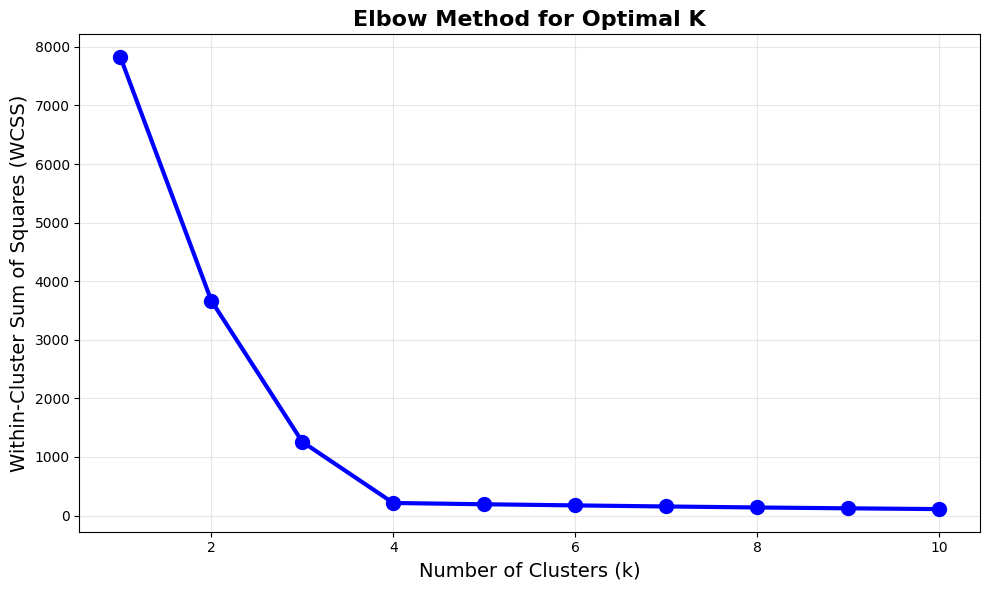

In [8]:
# Elbow Method to find optimal number of clusters
k_range = range(1, 11)
wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clean)
    wcss.append(kmeans.inertia_)

plot_elbow_method(k_range, wcss)

Looking at the plot, we see clearly a diminishing return at 3/4 clusters. These would be ideal values to choose as numbers of clusters when running K-Means. 

However real datasets often contain outliers, noise, and messy data. Let's stress-test K-means by adding some extreme outliers and see how robust it really is...

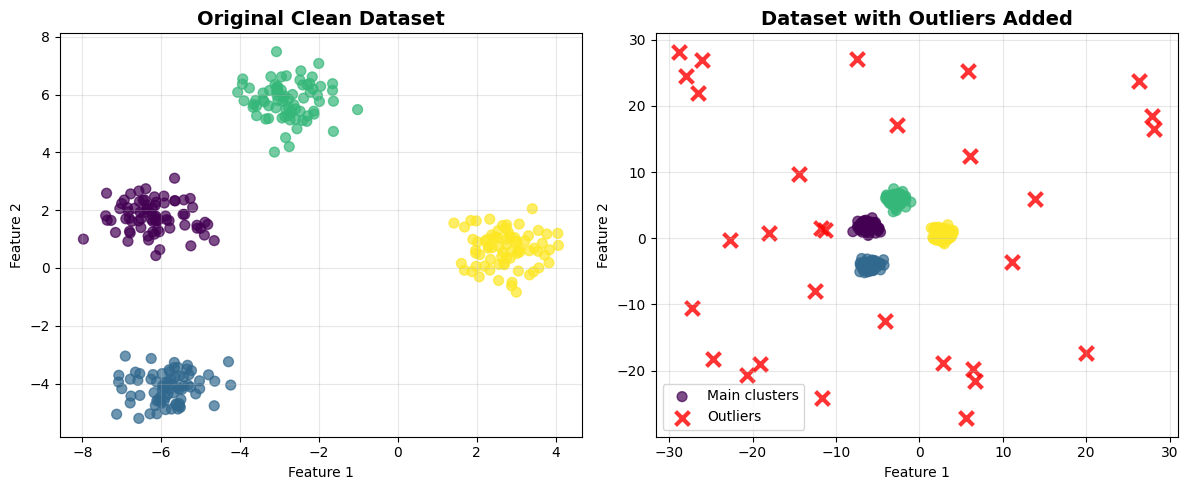

In [9]:
X_with_outliers, y_with_outliers = simulate_dataset_with_outliers(X_clean, y_true)

In [10]:
# Apply K-Means with k=4 (from elbow method)
kmeans = KMeans(n_clusters=4, random_state=40, n_init=10)
kmeans_labels = kmeans.fit_predict(X_with_outliers)
kmeans_centroids = kmeans.cluster_centers_

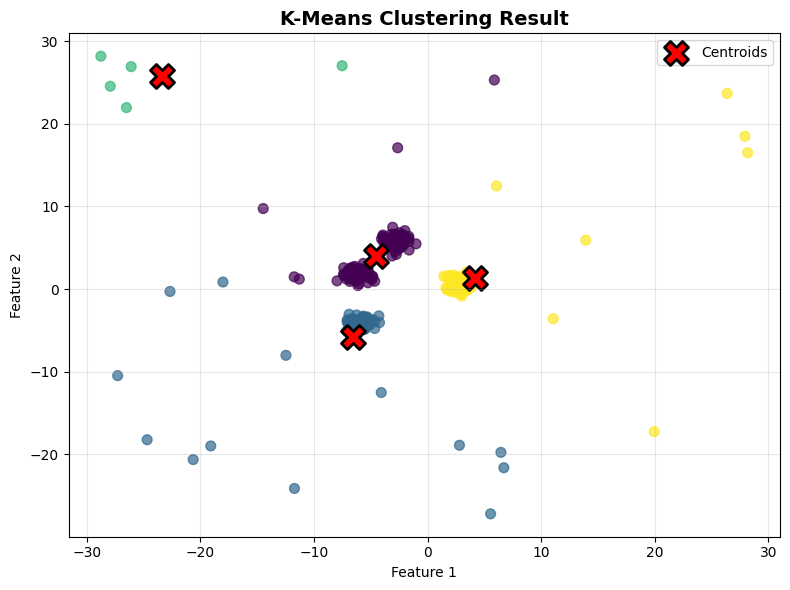

In [11]:
plot_kmeans_clusters(X_with_outliers, kmeans_labels, kmeans_centroids)

## From K-Means to K-Medoids

As we can see, K-Means is no longer able to detect the clusters properly due to the outliers, but we have a tool that can help us.

Let's explore **K-Medoids (Paritioning around medoids (PAM))** - a more robust alternative to K-Means.

### Key Differences:

- **Cluster centers**: K-Means uses calculated centroids vs K-Medoids uses actual data points (medoids)
- **Outlier sensitivity**: K-Medoids is more robust to outliers than K-Means
- **Distance metrics**: K-Medoids can use any distance metric, K-Means is limited to Euclidean

### When to Use K-Medoids:

- **Noisy data** with outliers
- **Better interpretability** - medoids are real samples
- **Non-Euclidean data** where averaging doesn't make sense

Let's apply K-Medoids to our dataset and compare the results!

In [12]:
# Apply K-Medoids with k=3 clusters
kmed = kmedoids.KMedoids(n_clusters=4, random_state=42)
euclidean_dist = pairwise_distances(X_with_outliers, metric='euclidean')
kmed.fit(euclidean_dist)

# Get cluster labels and medoid indices
kmedoids_labels = kmed.labels_
medoid_indices = kmed.medoid_indices_
medoids = X_with_outliers[medoid_indices]


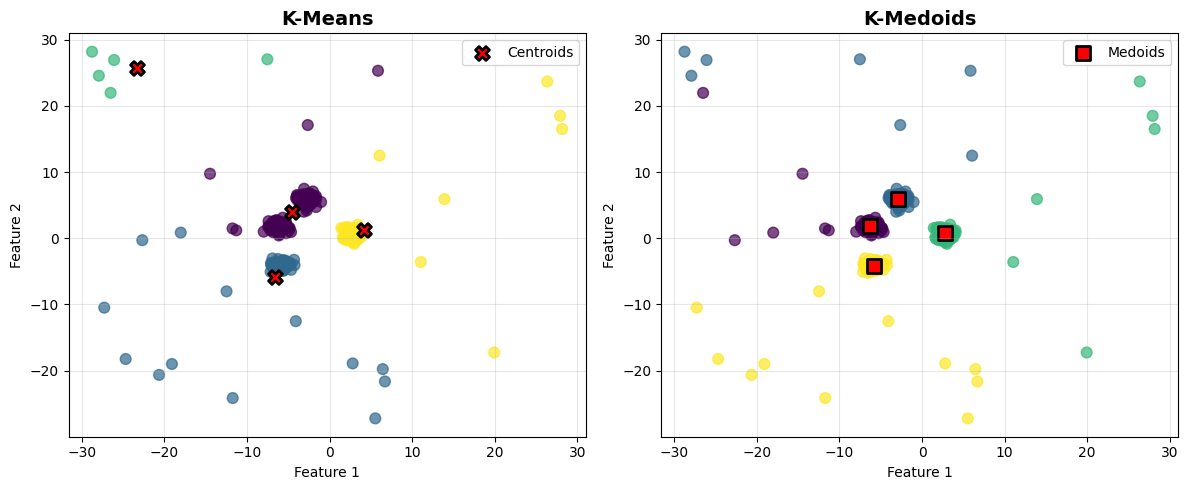

In [13]:
compare_kmeans_kmedoids(X_with_outliers, kmeans_labels, kmeans_centroids, kmedoids_labels, medoids)

**Perfect! Now with the extreme outliers we can clearly see that K-Medoids shines and doesn't overfit to the data!**

Notice the key differences:

- **K-Means centroids** (left plot): The red X markers are pulled away from the true cluster centers by the outliers, especially visible in the top cluster where the centroid is displaced toward the outlying points.

- **K-Medoids medoids** (right plot): The red square markers remain firmly within the actual cluster cores, as they must be real data points from the dataset. The outliers cannot "pull" the medoids away from the main clusters.

This demonstrates K-Medoids' **robustness to outliers** - a crucial advantage when dealing with real-world messy data!

## K-Means vs K-Medoids: Comparison

### Similarities:
- Both are partitional clustering methods that divide data into K clusters
- Must specify K beforehand
- Iterative algorithms with assignment and update steps
- Sensitive to initialization and assume similar cluster sizes

### Key Differences:

| Aspect | K-Means | K-Medoids |
|--------|---------|-----------|
| **Cluster Centers** | Calculated centroids | Actual data points |
| **Outlier Sensitivity** | High | Low |
| **Distance Metrics** | Euclidean only | Any metric |
| **Speed** | Faster | Slower |
| **Interpretability** | Centroids may not exist | Medoids are real samples |

### When to Use:

**K-Means:**
- Large datasets (computational efficiency)
- Clean data without outliers
- All continuous features

**K-Medoids:**
- Noisy data with outliers
- Need interpretable cluster centers
- Mixed data types or non-Euclidean distances

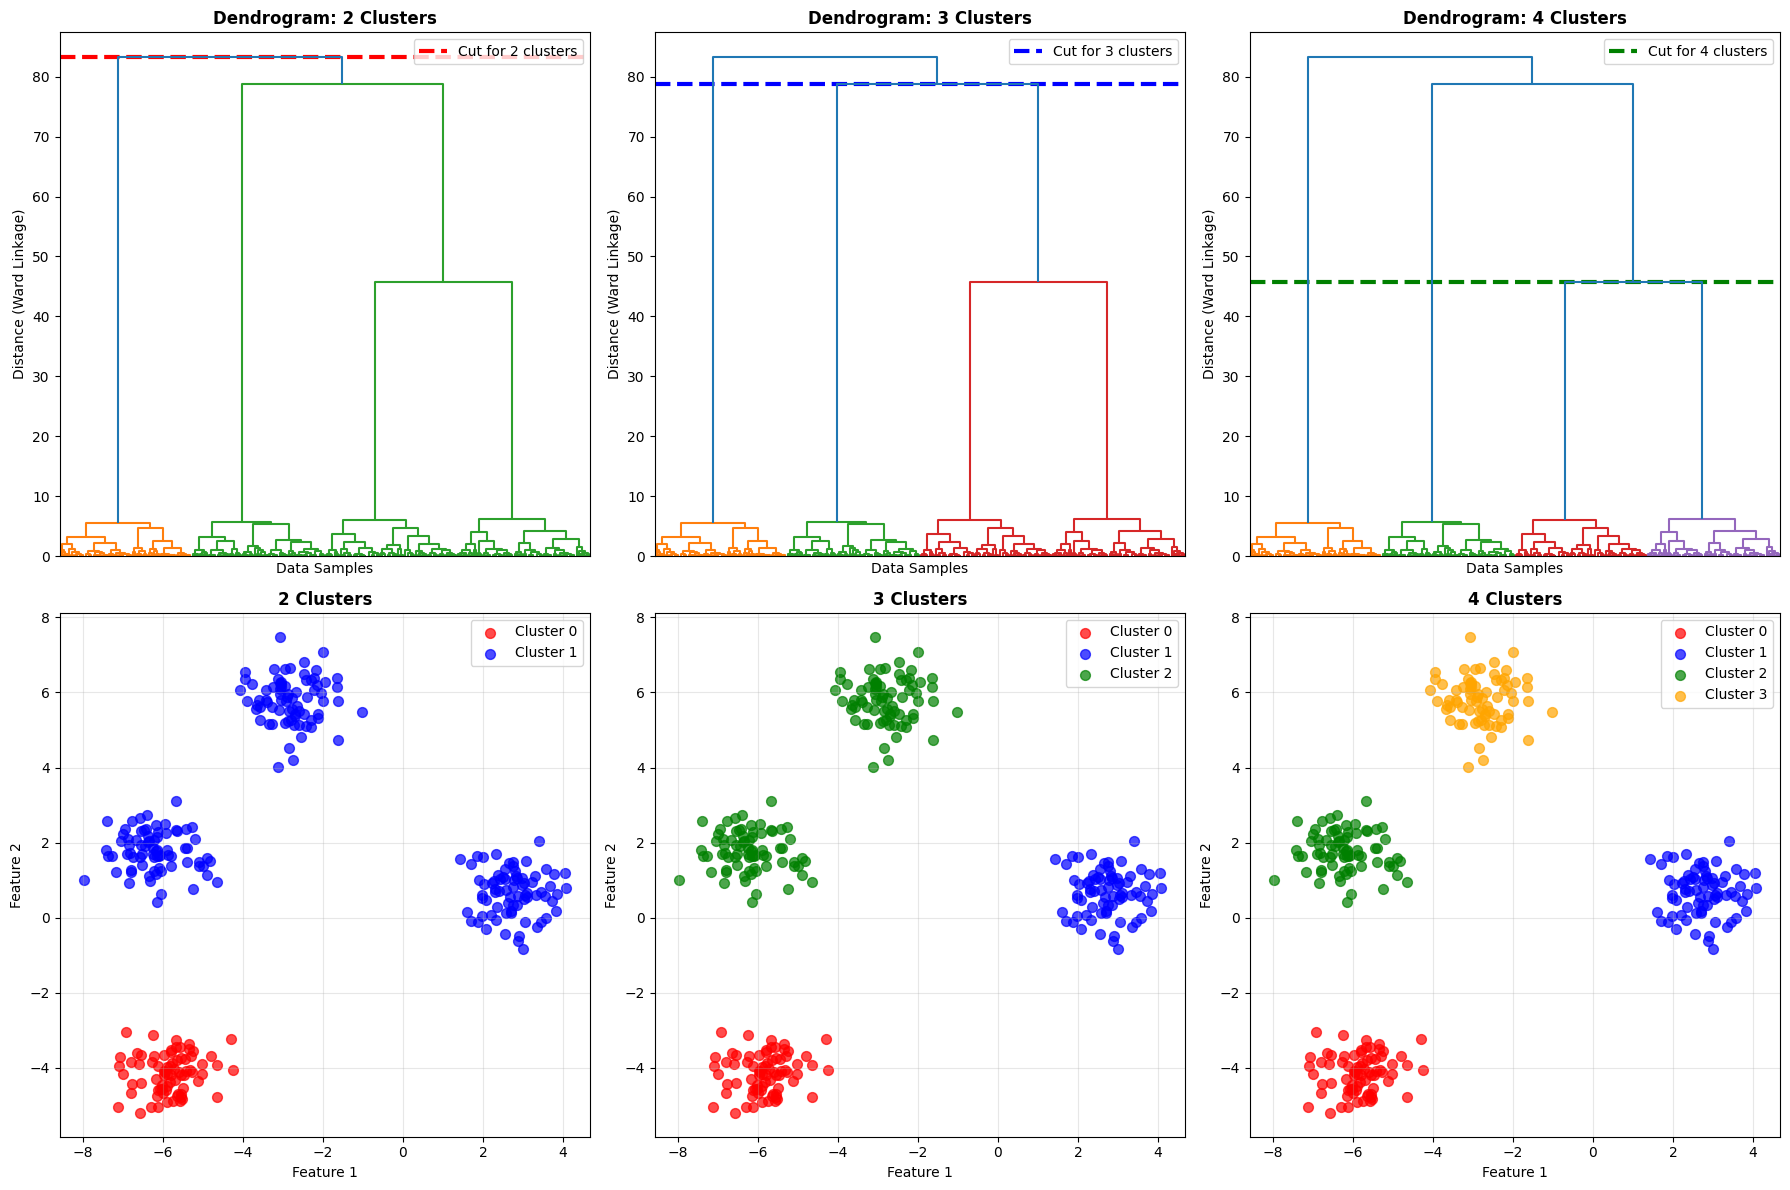

In [14]:
# TODO: Figure out where to put this code cell

# Create linkage matrix using Ward's method
linkage_matrix = linkage(X_clean, method='ward')

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Top row: Three dendrograms with different cluster cuts
n_clusters_list = [2, 3, 4]
colors_cuts = ['red', 'blue', 'green']
cluster_colors = ['red', 'blue', 'green', 'orange']

for i, n_clusters in enumerate(n_clusters_list):
    ax = axes[0, i]
    
    # Find the distance threshold for n_clusters
    if n_clusters <= len(linkage_matrix):
        threshold = linkage_matrix[-(n_clusters-1), 2]
        ax.axhline(y=threshold, color=colors_cuts[i], linestyle='--', linewidth=3,
                  label=f'Cut for {n_clusters} clusters')
    
    # Create dendrogram
    dend = dendrogram(linkage_matrix, 
                     p=10,
                     leaf_rotation=90,
                     leaf_font_size=8,
                     show_leaf_counts=False,
                     color_threshold=threshold,
                     ax=ax)
    
    ax.set_title(f'Dendrogram: {n_clusters} Clusters', fontsize=12, fontweight='bold')
    ax.set_xlabel('Data Samples', fontsize=10)
    ax.set_ylabel('Distance (Ward Linkage)', fontsize=10)
    ax.legend(loc='upper right')
    
    # Remove x-axis tick labels
    ax.set_xticks([])

# Bottom row: Cluster visualizations for 2, 3, 4 clusters
for i, n_clusters in enumerate([2, 3, 4]):
    ax = axes[1, i]
    
    # Get cluster labels for n_clusters
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1
    
    # Plot points colored by cluster
    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        ax.scatter(X_clean[mask, 0], X_clean[mask, 1], 
                  c=cluster_colors[cluster_id], s=50, alpha=0.7,
                  label=f'Cluster {cluster_id}')
        
    if n_clusters == 3:
        # Store results for comparison
        ward_linkage_labels = cluster_labels
        ward_linkage_matrix = linkage_matrix
    
    ax.set_title(f'{n_clusters} Clusters', fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
<br><br>
# **Hierarchical Clustering**

K-Means and K-Medoids require specifying the number of clusters K beforehand. **Hierarchical Clustering** offers an alternative approach that discovers the cluster structure without needing to choose K in advance.

### Key Advantages:
- **No need to specify K** - Algorithm reveals natural cluster structure
- **Dendrogram visualization** - Tree-based representation shows relationships between all data points
- **Multiple granularities** - extract different numbers of clusters from same result
- **Deterministic** - No random initialization, same result every time

### Types of Hierarchical Clustering:

**Agglomerative (Bottom-Up):**
- Start with each point as its own cluster
- Iteratively merge the two closest clusters
- Continue until all points are in one cluster
- Most common approach

**Divisive (Top-Down):**
- Start with all points in one cluster
- Iteratively split clusters into smaller ones
- Less common due to computational complexity

### How Agglomerative Clustering Works:

**Step 1: Initialize**
- Each data point starts as its own cluster (N clusters for N points)

**Step 2: Find Closest Clusters**
- Calculate distances between all cluster pairs
- Identify the two closest clusters

**Step 3: Merge**
- Combine the closest clusters into one
- Update distance matrix

**Step 4: Repeat**
- Continue merging until only one cluster remains
- Record the merge sequence in a dendrogram

There are different distance metrics that are used to compute hierarchical clusterings, in this context they are called *linkage*. We will look at 2 common ones **Ward's method** and **Average linkage**.

Let's see how hierarchical clustering reveals the structure in our dataset without outliers!

### Ward's Method

**Ward's linkage** is the most popular linkage criterion for hierarchical clustering because it creates compact, spherical clusters similar to K-Means.

#### How Ward's Method Works:
- **Objective**: Minimize the increase in within-cluster sum of squares (variance) when merging clusters
- **Strategy**: At each step, merge the two clusters that result in the smallest increase in total variance
- **Result**: Tends to create clusters of similar sizes with low internal variance
- **Balanced clusters** - Avoids creating very large or very small clusters

Now let's apply Ward's method to our wine dataset and learn how to read dendrograms!

In [15]:
# Create linkage matrix using Average Linkage method
linkage_matrix_ward = linkage(X_clean, method='ward')
cluster_labels_ward = fcluster(linkage_matrix_ward, 4, criterion='maxclust') - 1

# Or if you don't want to plot the dendrograms, you can use AgglomerativeClustering directly

ward_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
ward_labels = ward_clustering.fit_predict(X_clean)

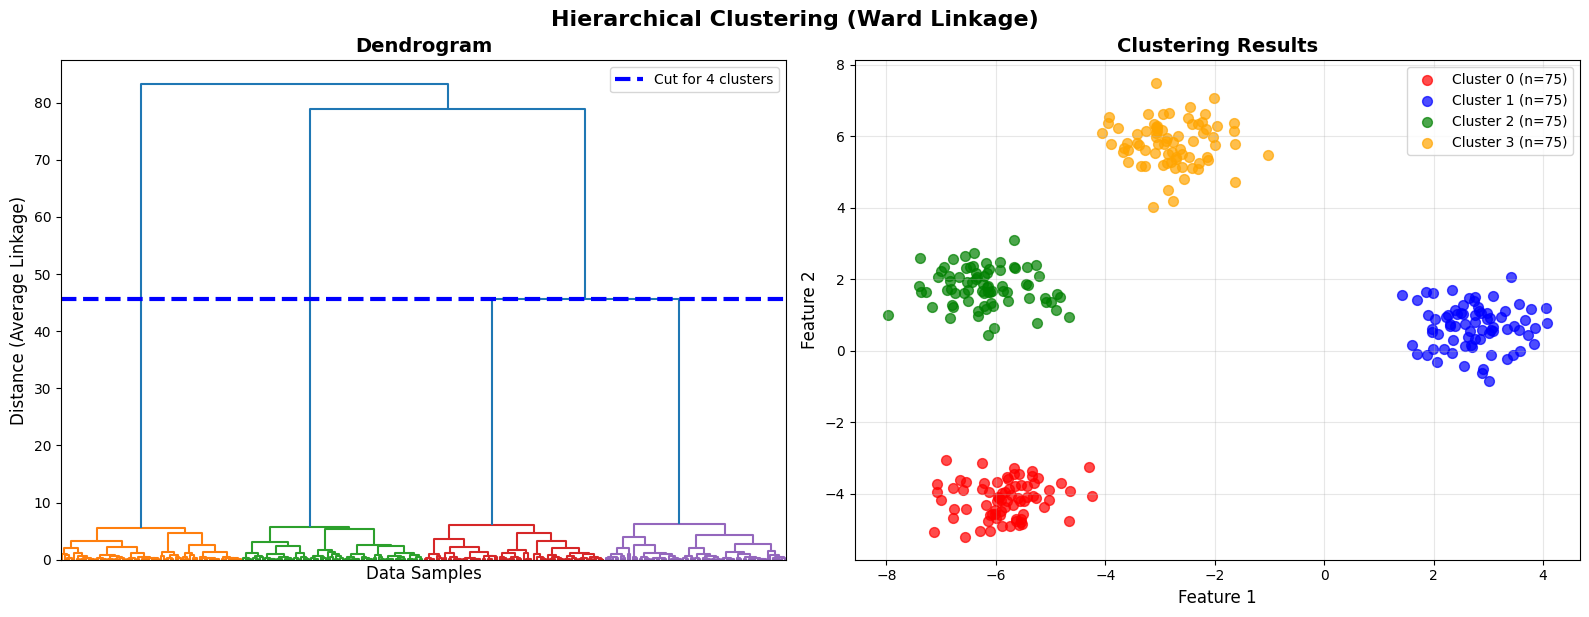

In [16]:
plot_hierarchical_clustering(X_clean, linkage_matrix_ward, cluster_labels_ward,
                             'Hierarchical Clustering (Ward Linkage)')

## How to Read Dendrograms

### Basic Structure:
- **Y-axis (Height)**: Distance at which clusters merge - higher means more dissimilar
- **X-axis**: Individual data points
- **Branches**: Show the hierarchical relationship between samples and clusters
- **Colors**: Different colors represent different clusters at the cut level

### Key Elements:
- **Leaf nodes** (bottom): Individual data points
- **Internal nodes**: Points where clusters merge
- **Branch height**: Indicates similarity - shorter branches = more similar samples
- **Merge distance**: The height where two branches join

### Using the Cut Line:
- **Horizontal dashed line**: Shows where to "cut" the tree for desired number of clusters
- **Count clusters**: Number of vertical lines the cut line crosses
- **Cluster membership**: Samples connected below the cut belong to same cluster
- **Color coding**: Each cluster gets a different color below the cut line

### Choosing Optimal Number of Clusters:
- **Look for large jumps**: Big increases in merge distance suggest natural cluster boundaries
- **Avoid high cuts**: Don't cut where merge distances are very large
- **Compare solutions**: Use visualization plots to see which clustering makes most sense

## Average Linkage Method

**Average linkage** (also called "UPGMA") uses the average distance between all pairs of points in different clusters as the merging criterion. It is a combination of two other linkage methods (single and complete)

### How Average Linkage Works:
- **Objective**: Merge clusters with the smallest average distance between all point pairs
- **Strategy**: Calculate mean distance between every point in cluster A and every point in cluster B
- **Result**: Creates moderately compact clusters, balancing single and complete linkage extremes
- **Compromise approach** - Less sensitive to outliers than single, less conservative than complete

### Why Use Average Linkage?
- **Stable results** - Less affected by individual outlier points
- **Good general purpose** - Works well for many different cluster shapes and sizes

Let's see how Average Linkage performs!

In [17]:
# Create linkage matrix using Average Linkage method
linkage_matrix_average = linkage(X_clean, method='average')
cluster_labels_average = fcluster(linkage_matrix_average, 4, criterion='maxclust') - 1


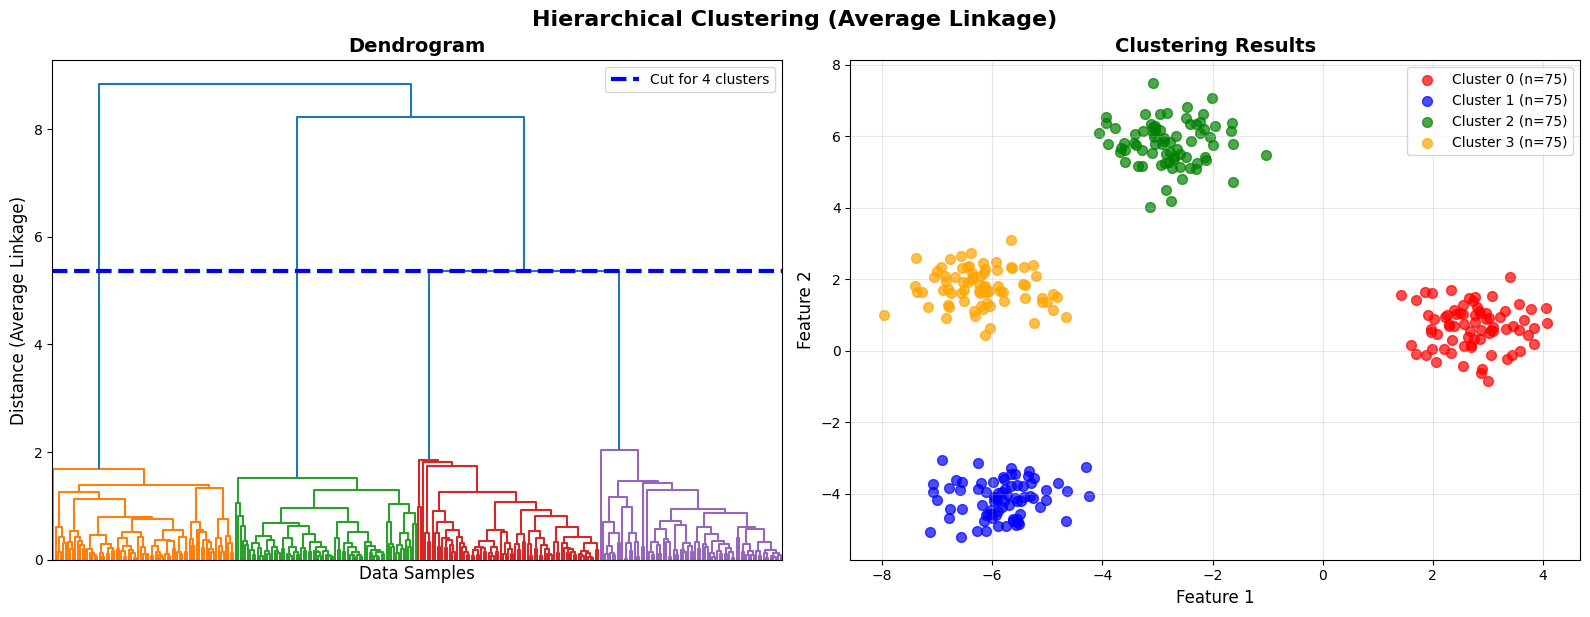

In [18]:
plot_hierarchical_clustering(X_clean, linkage_matrix_average, cluster_labels_average,
                             'Hierarchical Clustering (Average Linkage)')

### Key Observations - Average Linkage:

- **Well-balanced clusters**: Cluster sizes (65, 50, 63) are very evenly distributed across wine samples
- **Moderate clustering approach**: Balances between single linkage's chaining tendency and complete linkage's compactness
- **Clear separation**: Creates distinct, well-separated clusters
- **Robust to outliers**: Less sensitive to noise than single linkage while avoiding over-conservative merging

**However, we still have the same issues with noisy data.** 

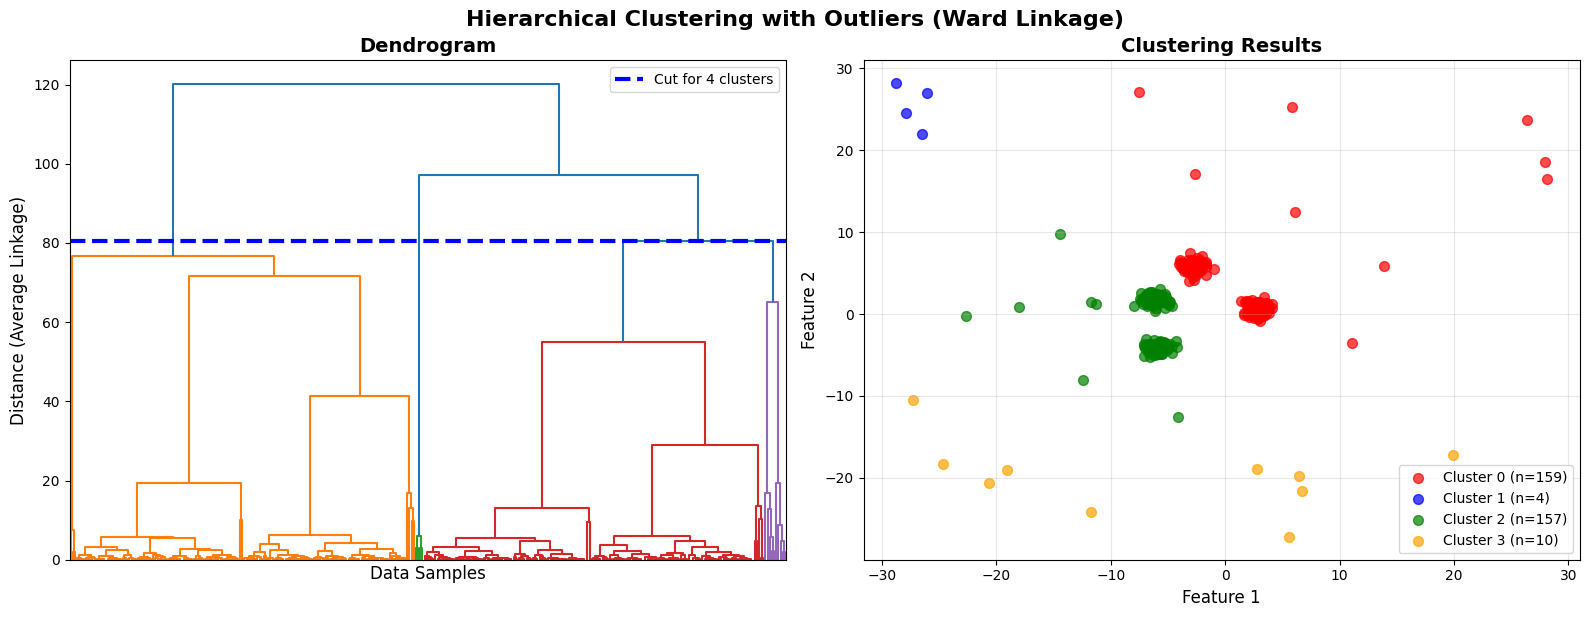

In [19]:
# Create linkage matrix using Average Linkage method
linkage_matrix_outliers = linkage(X_with_outliers, method='ward')
cluster_labels_outliers = fcluster(linkage_matrix_outliers, 4, criterion='maxclust') - 1

plot_hierarchical_clustering(X_with_outliers, linkage_matrix_outliers, cluster_labels_outliers,
                             'Hierarchical Clustering with Outliers (Ward Linkage)')


Looking at the hierarchical clustering results above, we can see that even this different approach struggles with our outlier-contaminated dataset. Notice how:

- **Unbalanced clusters**: Some clusters have very few points (like Cluster 1 with only 4 points) while others are much larger
- **Outlier sensitivity**: The outliers are either forming their own tiny clusters or being incorrectly merged with main clusters
- **Inconsistent grouping**: The algorithm has difficulty distinguishing between true cluster members and noise points

This demonstrates that **outliers remain a fundamental challenge** across different clustering algorithms, not just K-Means. The hierarchical approach, while useful for understanding data structure, doesn't inherently solve the robustness problem we've been exploring.

## Hierarchical Clustering Overview

Hierarchical clustering builds a tree of clusters by iteratively merging the closest pairs. Unlike K-means, it doesn't require specifying the number of clusters beforehand and provides a complete clustering hierarchy.

### Linkage Methods Comparison

Here's an overview of the different linkages. We have also added two more linkages for a broader overview.

| Method | Distance Calculation | Characteristics | Best For |
|--------|---------------------|-----------------|----------|
| **Single** | Minimum distance between any two points | Creates chains, sensitive to outliers | Non-spherical, density-based clusters |
| **Complete** | Maximum distance between any two points | Compact, tight clusters | Well-separated, spherical clusters |
| **Average** | Average distance between all point pairs | Moderate approach, balanced | General purpose, moderate noise |
| **Ward's** | Minimizes within-cluster variance | Balanced sizes, spherical clusters | Most datasets, similar to K-means |

### When to Use Hierarchical Clustering:
- **Exploratory analysis** - when you don't know the number of clusters
- **Small to medium datasets** (computational complexity is O(n³))
- **Need cluster hierarchy** - understanding relationships between clusters
- **Deterministic results** - same input always gives same output

---
<br><br>
# **Testing on Non-Spherical Data: Moons and Circles**

So far we've seen how outliers can disrupt clustering algorithms. But there's another fundamental limitation: **shape assumptions**. 

K-Means, K-Medoids, and Hierarchical clustering all assume clusters are roughly **spherical** or **convex**. What happens when we encounter datasets with complex, non-linear shapes?

Let's test our algorithms on two classic challenging datasets:
- **Moons**: Two interleaving crescent shapes
- **Circles**: Concentric circular patterns

These datasets will reveal whether our current clustering methods can handle real-world data structures that don't fit the "blob-like" assumption.

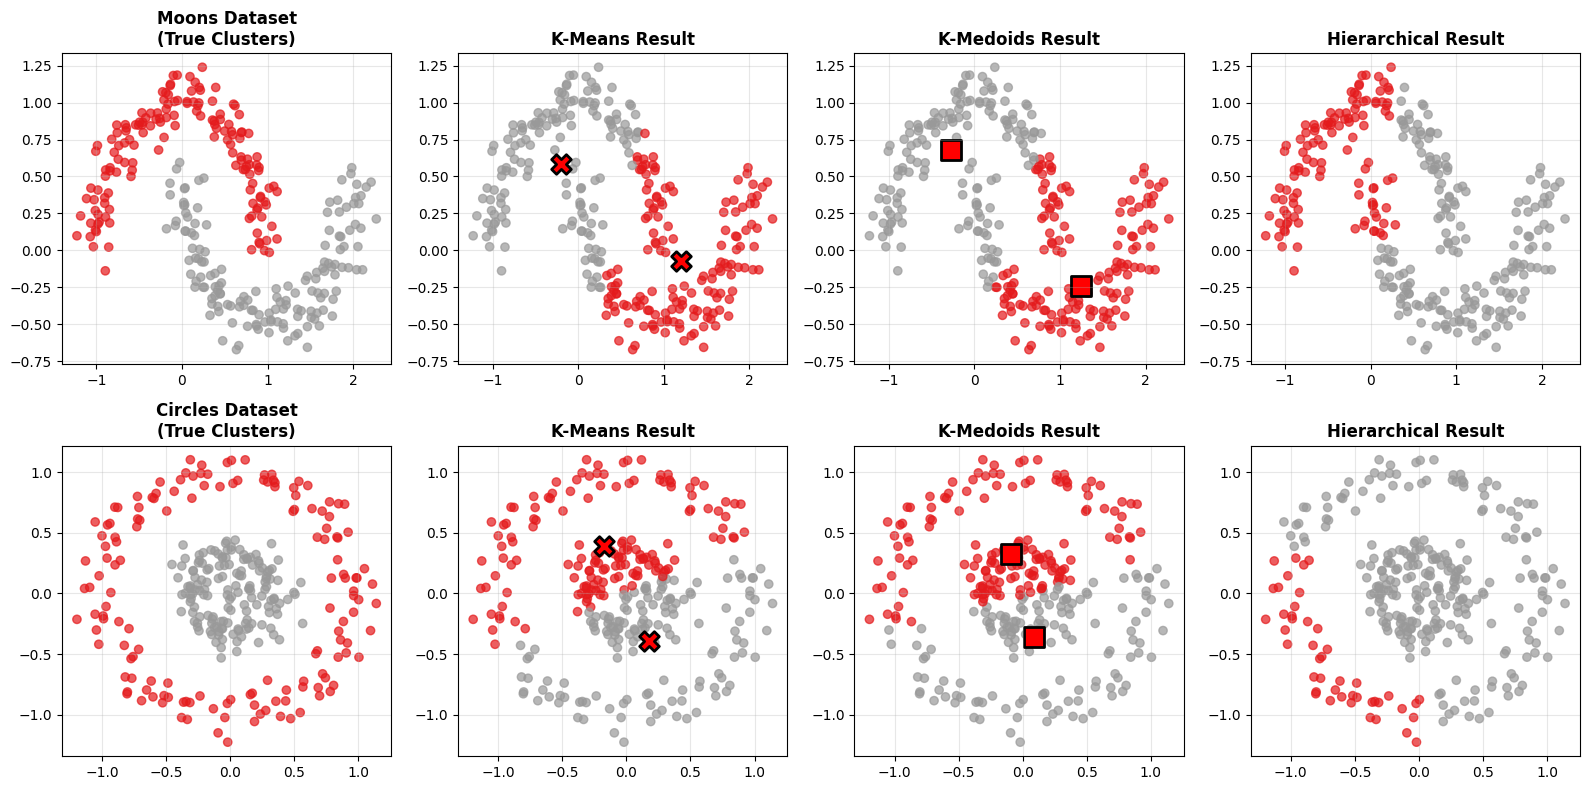

In [20]:
X_moons, y_moons, X_circles, y_circles = generate_non_spherical_data()

## Key Observations: When Shape Matters

The results show that all three traditional clustering algorithms struggle dramatically with non-spherical data:

### Moons Dataset:
- **K-Means & K-Medoids**: Split each crescent moon vertically instead of separating the two moons
- **Hierarchical**: Performs slightly better but still mixes points from both crescents

### Circles Dataset:  
- **K-Means & K-Medoids**: Create arbitrary radial splits rather than recognizing the concentric structure
- **Hierarchical**: Completely fails to distinguish inner from outer circle

### The Core Problem:
All these algorithms assume **spherical clusters** and use **Euclidean distance** as their primary metric. They fundamentally cannot detect clusters based on **density** or **connectivity**.

We need a different approach - one that can discover clusters of arbitrary shape by focusing on local density rather than global geometry. Let's explore a tool that can handle exactly these challenging scenarios!

---
<br><br>
# **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**

K-Means, K-Medoids, and Hierarchical Clustering all assume clusters have similar sizes and spherical shapes. **DBSCAN** takes a fundamentally different approach by finding clusters based on local density rather than geometric assumptions.

### Key Advantages:
- **No need to specify number of clusters** - Algorithm discovers clusters automatically
- **Handles arbitrary cluster shapes** - Not limited to spherical clusters like K-means
- **Robust to outliers** - Identifies and labels noise points explicitly
- **Density-based** - Finds clusters of varying sizes and densities
- **Deterministic** - Same parameters always give same results

### Core Concepts:

**Dense Regions vs Sparse Regions:**
- **Core idea**: Clusters are dense regions separated by sparse regions
- **Noise points**: Isolated points in low-density areas
- **Arbitrary shapes**: Can find elongated, curved, or irregular clusters

### How DBSCAN Works:

**Step 1: Define Density**
- **ε (epsilon)**: Maximum distance to consider points as neighbors
- **MinPts**: Minimum number of points required to form a dense region

**Step 2: Classify Points**
- **Core points**: Have at least MinPts neighbors within ε distance
- **Border points**: Not core points but within ε of a core point
- **Noise points**: Neither core nor border points

**Step 3: Form Clusters**
- Start with any unvisited core point
- Add all density-reachable points to the same cluster
- Repeat until all core points are processed

**Step 4: Handle Remaining Points**
- Border points join the cluster of nearest core point
- Noise points remain unassigned (labeled as -1)

### The Parameter Challenge:
The biggest challenge with DBSCAN is choosing appropriate **ε** and **MinPts** parameters. We'll explore systematic approaches to parameter selection and see how DBSCAN finally succeeds where traditional methods failed!

Let's start by finding an appropriate **ε**.

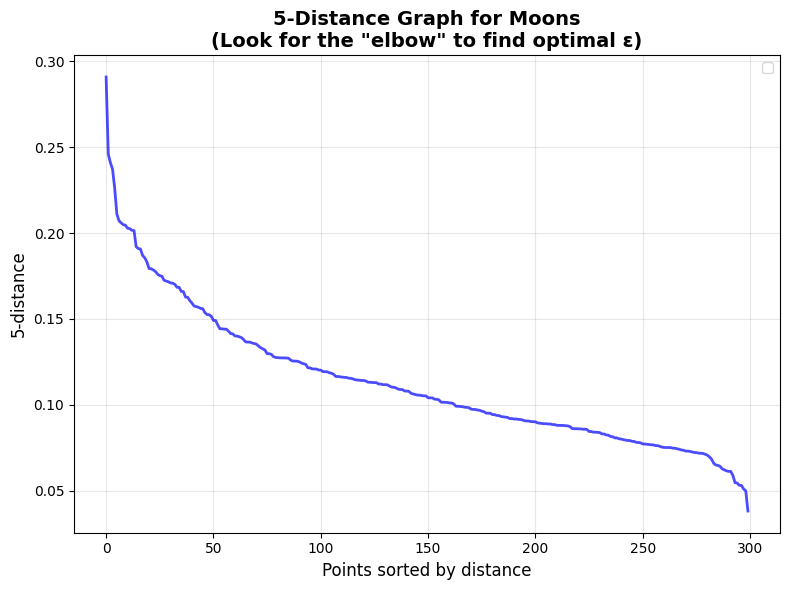

In [21]:
# Moons dataset
k_dist_moons = plot_k_distance_graph(X_moons, k=5, dataset_name="Moons")


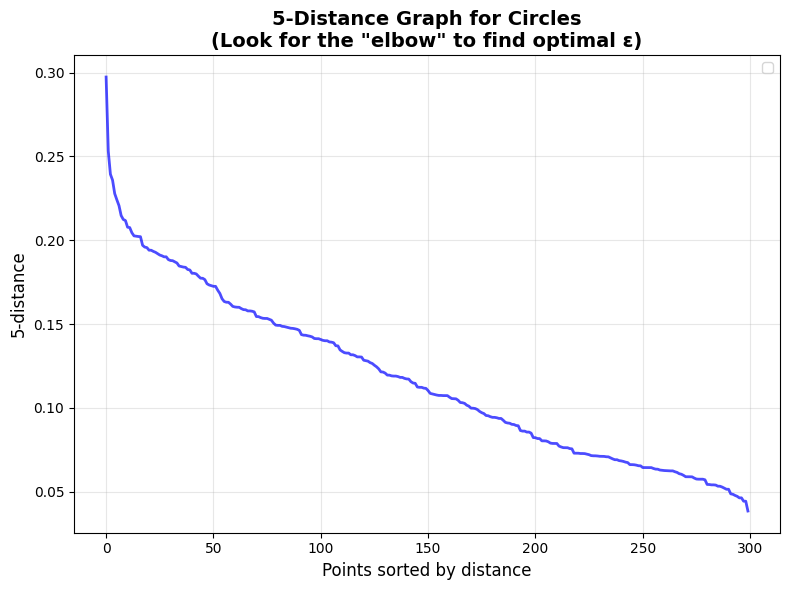

In [22]:
# Circles dataset  
k_dist_circles = plot_k_distance_graph(X_circles, k=5, dataset_name="Circles")

### Understanding the K-Distance Graph

The **k-distance graph** is a crucial tool for selecting the optimal ε parameter in DBSCAN. Here's how to interpret it:

#### What the Graph Shows:
- **X-axis**: All data points sorted by their distance to the k-th nearest neighbor (k=5 here)
- **Y-axis**: The actual distance to that k-th nearest neighbor
- **Curve shape**: Shows the distribution of local densities in your dataset

#### How to Use It:
- **Look for the "elbow" or "knee"**: The point where the curve changes from gradual to steep
- **Reality check**: In our plots, **no clear elbow is visible** - the curves show gradual transitions
- **This is common**: Real datasets often don't have obvious elbows, making parameter selection challenging

#### Why This Works (In Theory):
- **Dense regions** (right side): Points have close neighbors → small k-distances
- **Sparse regions** (left side): Points are isolated → large k-distances  
- **The elbow**: Should separate dense cluster cores from sparse noise/boundaries

#### The Parameter Selection Challenge:
- **No clear elbow**: Both datasets show smooth, gradual curves without sharp transitions
- **Trial and error needed**: Must test different ε values and evaluate clustering quality
- **This is DBSCAN's main limitation**: Parameter selection often requires experimentation

#### What Different ε Values Mean:
- **Too small ε** (< 0.15): Only very dense cores become clusters → many noise points
- **Reasonable testing range** (0.15-0.22): Based on our k-distance analysis, this seems like a sensible range to start testing for both datasets
- **Candidate range** (≈ 0.17-0.22): Focus on these values from the percentile suggestions
- **Too large ε** (> 0.22): Sparse regions get merged → few large clusters

**Bottom line**: The k-distance graph provides guidance, but we still need to test multiple ε values to find the best clustering results.



### Finding Suitable MinPts

While the k-distance graph helps with ε selection, choosing **MinPts** also requires consideration:

#### Common Rules of Thumb:

1. **Dimensionality-based**: MinPts ≥ D + 1, where D = number of features
   - For our 2D datasets: MinPts ≥ 3
   - **Limitation**: This rule can be too conservative for high-dimensional data

2. **General recommendation**: MinPts = 4 or 5 for most 2D problems
   - **Why**: Provides good balance between noise detection and cluster formation
   - **Our choice**: We used MinPts = 5 (hence k=4 in the k-distance graph)

3. **Domain-specific**: Consider the minimum meaningful cluster size
   - **Question**: What's the smallest group that makes sense in your context?
   - **Example**: For customer segmentation, maybe 10+ customers per segment

#### Testing Strategy:
- **Start with MinPts = 4-5** for 2D data
- **Lower values (2-3)**: More sensitive to noise, might create many small clusters
- **Higher values (6-10)**: More robust to noise, but might merge small legitimate clusters
- **Systematic approach**: Test combinations of (ε, MinPts) and evaluate results

#### The Reality:
**No perfect formula exists** - both ε and MinPts often require experimentation based on:
- Dataset characteristics
- Domain knowledge  
- Desired cluster granularity
- Tolerance for noise points

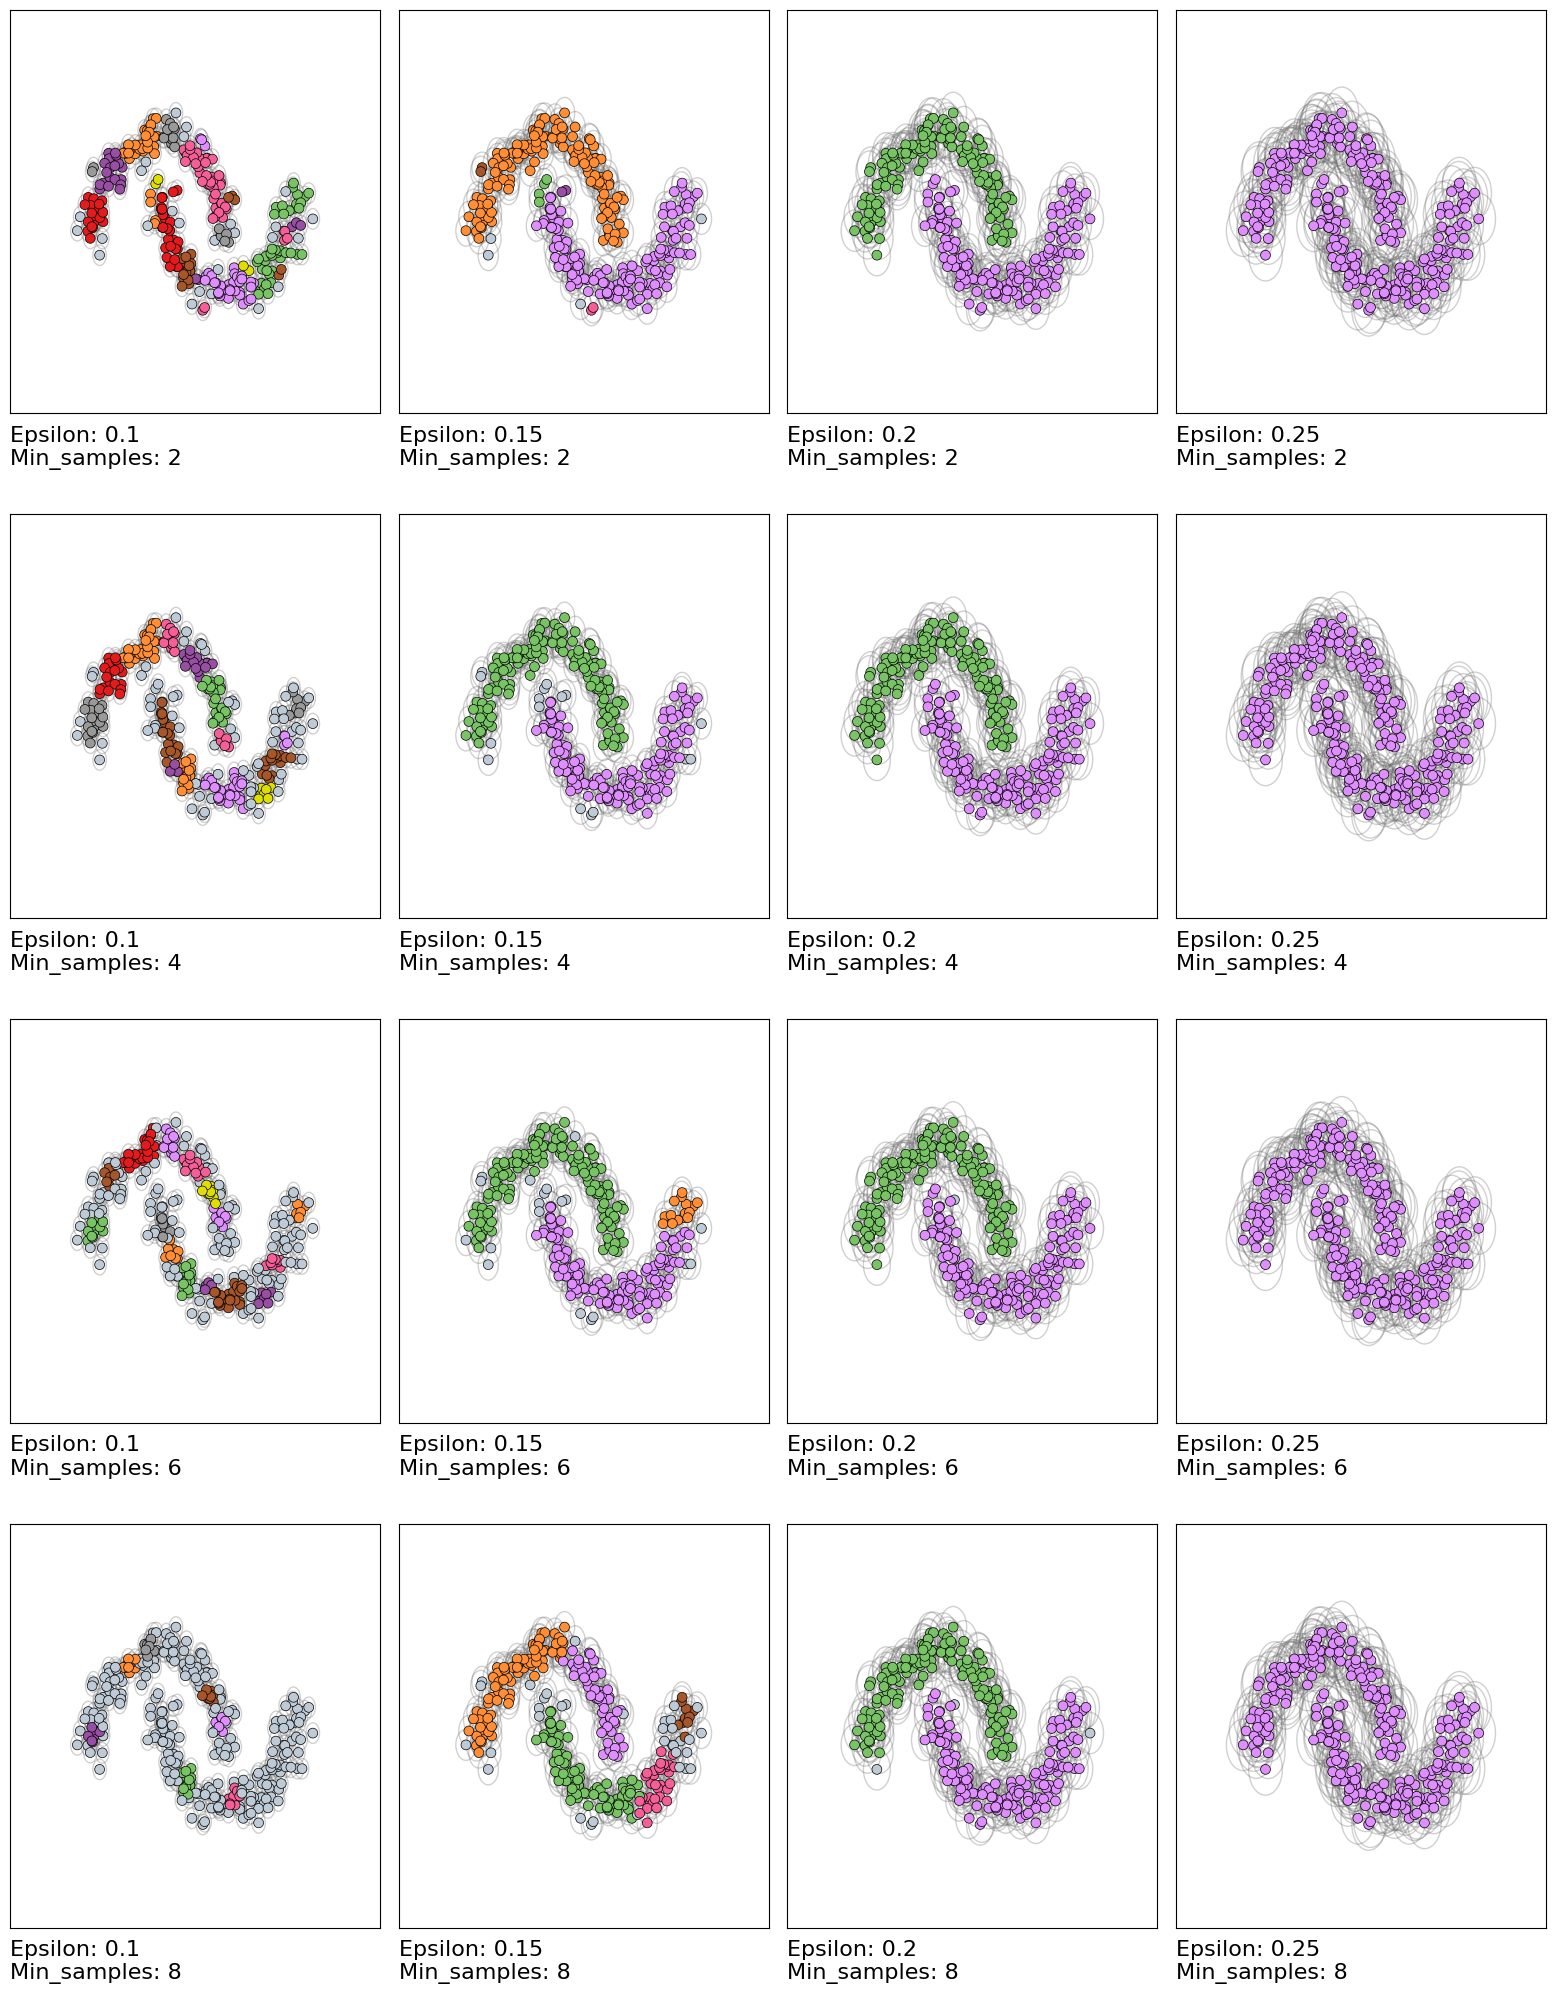

In [23]:
plot_dbscan_grid(X_moons, eps_values=[0.1, 0.15, 0.2, 0.25], min_samples_values=[2, 4, 6, 8])

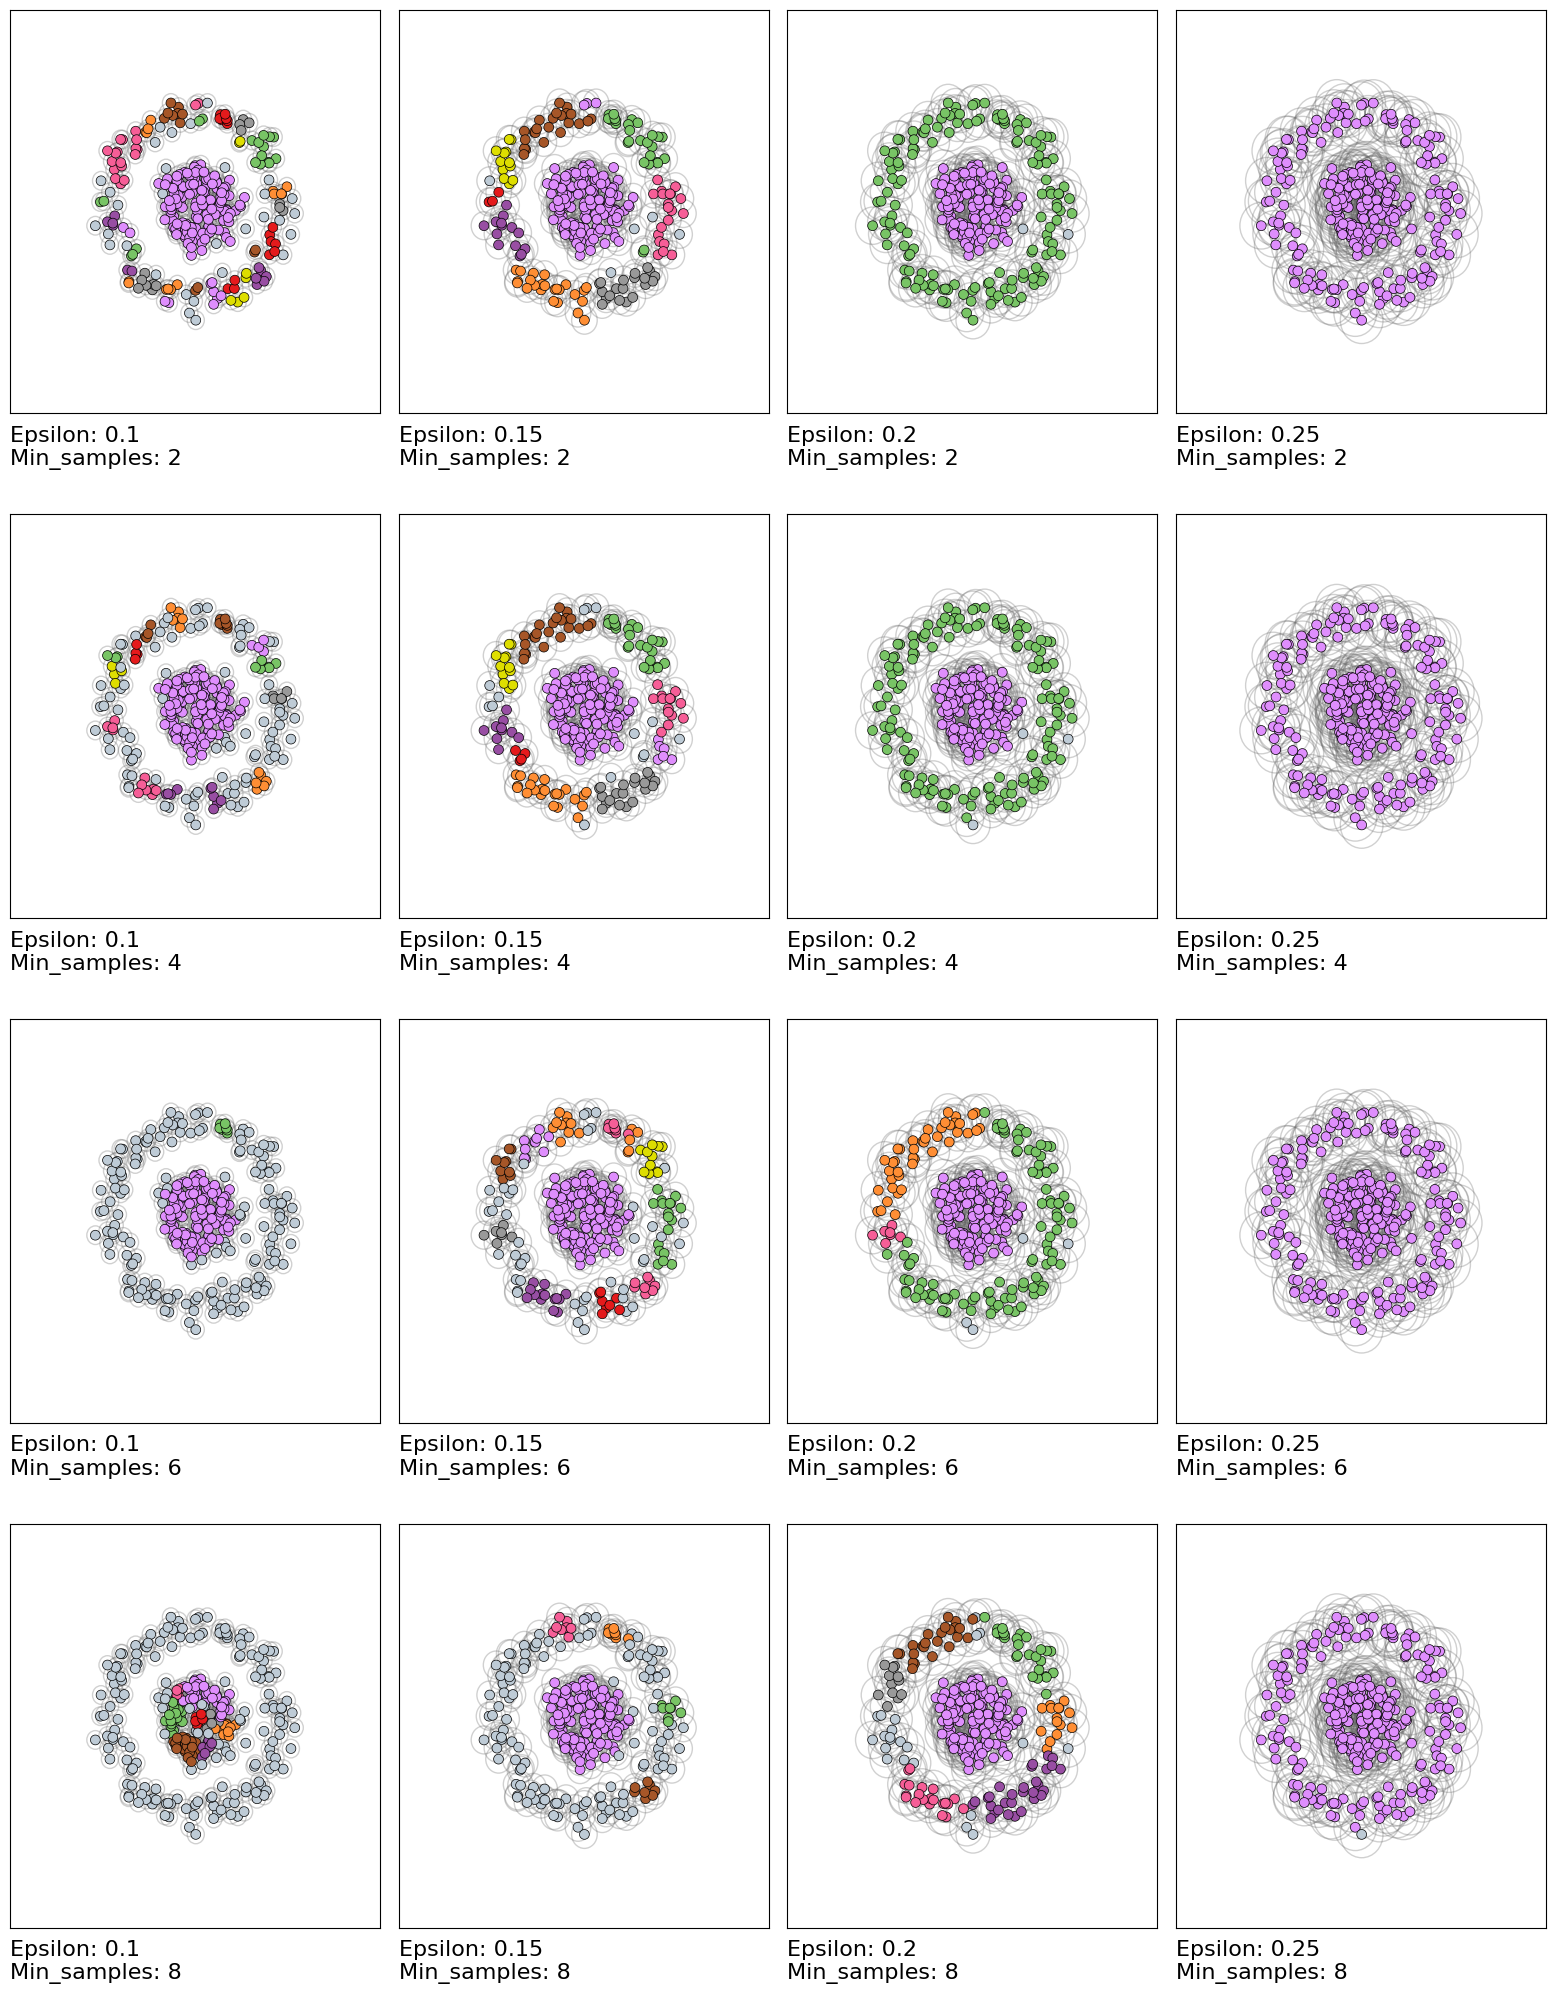

In [24]:
plot_dbscan_grid(X_circles, eps_values=[0.1, 0.15, 0.2, 0.25], min_samples_values=[2, 4, 6, 8])

In [ ]:
# TODO: Show an example on how to use DBSCAN with the moons dataset

### DBSCAN Parameter Effects

**ε (epsilon)**: Maximum distance between points to be considered neighbors
**MinPts**: Minimum number of neighbors required for a point to be a "core point"

### Key Observations from Parameter Grid:

**ε Effect (horizontal comparison):**
- **Small ε (0.1)**: Very strict neighborhoods → few clusters, lots of noise
- **Medium ε (0.3)**: Too many tiny clusters (over-segmentation)
- **Larger ε (0.5-1.0)**: Balanced clustering with reasonable cluster sizes

**MinPts Effect (vertical comparison):**
- **Low MinPts (2)**: Less strict density requirement → fewer noise points
- **High MinPts (5)**: Stricter density requirement → more noise points

**Best Results:**
- **ε=0.5, MinPts=5**: Clean separation into 3 clusters (matches wine varieties!)
- **ε=1.0, MinPts=4**: Also good with 3 well-separated clusters
- **Sweet spot**: ε around 0.5-1.0 captures the natural wine variety structure

The k-distance graph suggestion (ε≈0.29) was close but slightly conservative - real-world parameter tuning often requires experimentation around the suggested value.

---
<br><br>
# **Clustering Methods Overview**

### K-Means & K-Medoids Clustering
- **Advantages:**
  - Fast and scalable for large datasets (K-Means faster)
  - Simple to implement and understand
  - Works well with spherical, similar-sized clusters
  - **K-Medoids**: More robust to outliers, uses actual data points as centers

- **Disadvantages:**
  - Must specify k beforehand
  - Assumes spherical clusters
  - **K-Means**: Sensitive to outliers and initialization
  - **K-Medoids**: Slower than K-Means, still sensitive to initialization

### Hierarchical Clustering
- **Advantages:**
  - No need to specify number of clusters
  - Provides complete hierarchy (dendrogram)
  - Deterministic results

- **Disadvantages:**
  - Computationally expensive O(n³)
  - Poor scalability for large datasets
  - Sensitive to noise and outliers

### DBSCAN
- **Advantages:**
  - Automatically finds number of clusters
  - Handles arbitrary shapes and noise/outliers
  - No cluster shape assumptions

- **Disadvantages:**
  - Challenging parameter tuning (ε, MinPts)
  - Struggles with varying densities
  - Requires experimentation to get right

### Quick Selection Guide

| Use Case | Best Method |
|----------|-------------|
| **Large datasets, spherical clusters** | K-Means |
| **Medium datasets, robust to outliers** | K-Medoids |
| **Small datasets, need hierarchy** | Hierarchical |
| **Complex shapes, noisy data** | DBSCAN |

If your dataset allows it feel free to use differetn methods and compare their outputs! Let's transfer our knowledge to a medical dataset next!

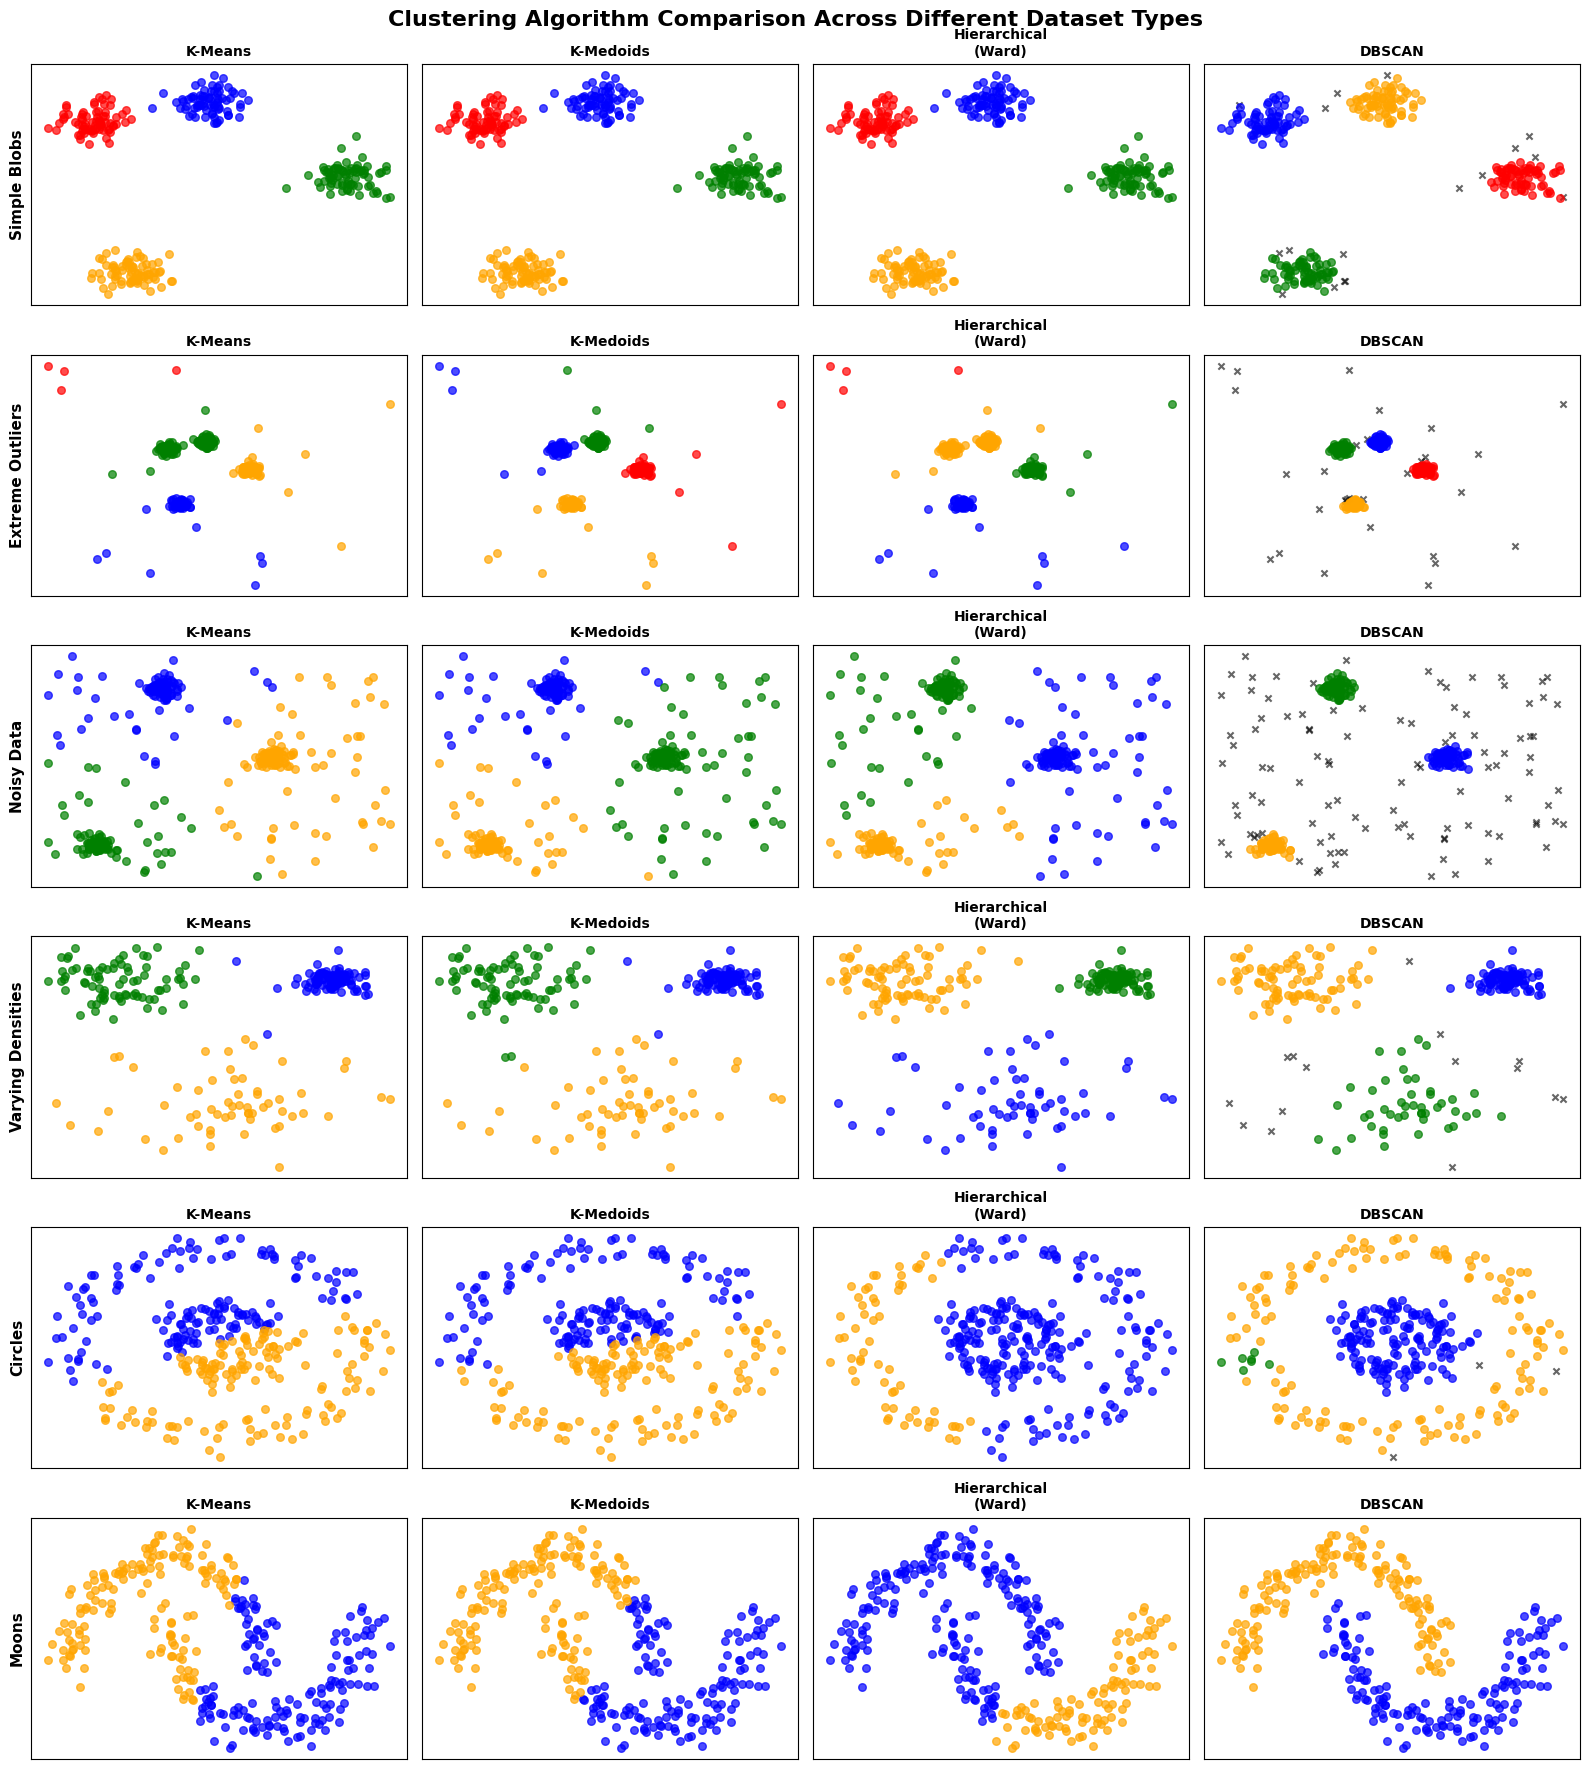

In [25]:
# Create the comparison plot
plot_clustering_comparison()

---
<br><br>
# **Applying Clustering to Medical Data**

Now that we've mastered clustering techniques on simulated data, let's explore how these same methods can reveal patterns in medical datasets. Understanding patient groups can help identify disease subtypes, risk profiles, and treatment pathways.

## TCGA Pan-Cancer Gene Expression Dataset

For illustration purposes we use the **TCGA (The Cancer Genome Atlas) Pan-Cancer Gene Expression dataset**. It contains RNA sequencing data from tumor samples across multiple cancer types to enable comprehensive cancer genomics analysis.

**Dataset Overview:**
- **500 tumor samples** (subset from original ~800 samples for computational advantages)
- **10,000 gene expression features** (subset of most variable genes from original ~20,000 genes)
- **5 cancer types** with maintained proportional distribution from original dataset
- **Clinical relevance:** Real tumor gene expression profiles from major cancer research consortium
nal complexity while preserving biological diversity

Let's apply the learned clustering algorithms on this dataset!

In [26]:
# Load gene expression data
gene_data = pd.read_csv('gene_data.csv', index_col=0)
gene_labels = gene_data[['Cancer_Type']]

In [27]:
gene_data.head()

gene_9176  gene_9175  gene_15898  gene_15301  gene_15589  \
sample_545  10.359782   7.446877    0.505891    1.422287   14.455790   
sample_726   0.970780   2.453992    0.000000    0.000000   12.281307   
sample_409   0.000000   0.890797    0.000000    0.000000   12.891476   
sample_28    0.000000   0.000000    2.216703    0.000000    6.194489   
sample_630   1.001514   1.461319    1.461319    0.000000    9.654475   

            gene_3540  gene_19661  gene_3541  gene_11250  gene_15897  ...  \
sample_545   5.695557   13.737268   8.952398    7.460702    2.257101  ...   
sample_726   8.181083   13.025922  11.630904    5.085552    5.816387  ...   
sample_409  10.321015   13.270974   9.053062    6.042651    3.563158  ...   
sample_28    0.000000    9.271526   2.216703    2.610606    1.298248  ...   
sample_630   8.026723   12.476966   8.935925    3.360238    2.089735  ...   

            gene_19048  gene_6439  gene_471  gene_16148  gene_7927  gene_4668  \
sample_545    9.843573   6.073940  7.997417   11.721633   6.091820   7.044678   
sample_726    8.400491   5.660852  8.255472   10.031494   7.513593   9.105751   
sample_409    7.729797   6.800615  8.443341   11.255229   8.104352   9.508025   
sample_28    10.993604   4.181659  8.373022   10.823964   6.615371   7.067725   
sample_630    7.785962   5.737633  7.635957    9.661632   8.022556   8.646627   

            gene_10830  gene_4321  gene_11676  Cancer_Type  
sample_545    7.631868   2.782513   13.037116         BRCA  
sample_726    4.242610   1.378401   13.021381         BRCA  
sample_409    5.396009   2.473995   11.353638         BRCA  
sample_28     5.986258   1.497842   13.630677         BRCA  
sample_630    6.592749   1.909082   13.182810         BRCA  

[5 rows x 10001 columns]

Dataset Overview:
   - Samples (patients): 498
   - Features (genes): 10001
   - Data size: 498 × 10001


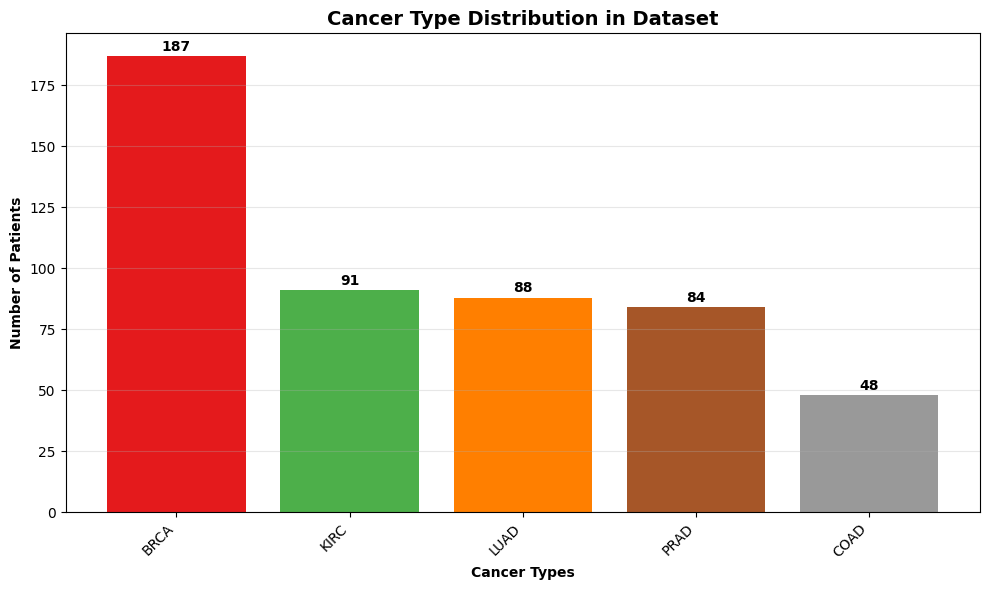

In [28]:
gene_info(gene_data)

# Drop the label column from the data
gene_data = gene_data.drop(columns=['Cancer_Type'])

Let's start by applying K-Means on the raw high-dimensional data with 10'000 features. We visualize the clusterings using the first 2 PC-Components.

In [29]:
# Prepare the data
X_raw = gene_data.values
y_true = gene_labels.iloc[:, 0].values

# Standardize the data
scaler = StandardScaler()
X_raw_scaled = scaler.fit_transform(X_raw)

# Determine number of clusters from true labels
n_clusters = len(np.unique(y_true))

In [30]:
# Apply K-Means on raw data
kmeans_raw = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_raw = kmeans_raw.fit_predict(X_raw_scaled)
centroids_raw = kmeans_raw.cluster_centers_

In [31]:
# Evaluate clustering performance
ari_raw = adjusted_rand_score(y_true, labels_raw)
sil_raw = silhouette_score(X_raw_scaled, labels_raw)


In [32]:
# Apply PCA for visualization (10 components, because we will use them later)
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_raw_scaled)

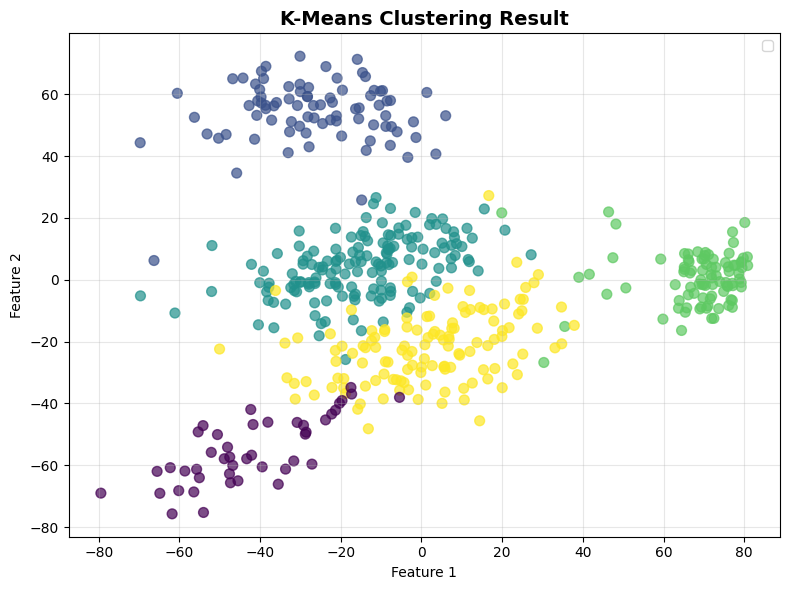

In [33]:
plot_kmeans_clusters(X_pca, labels_raw)

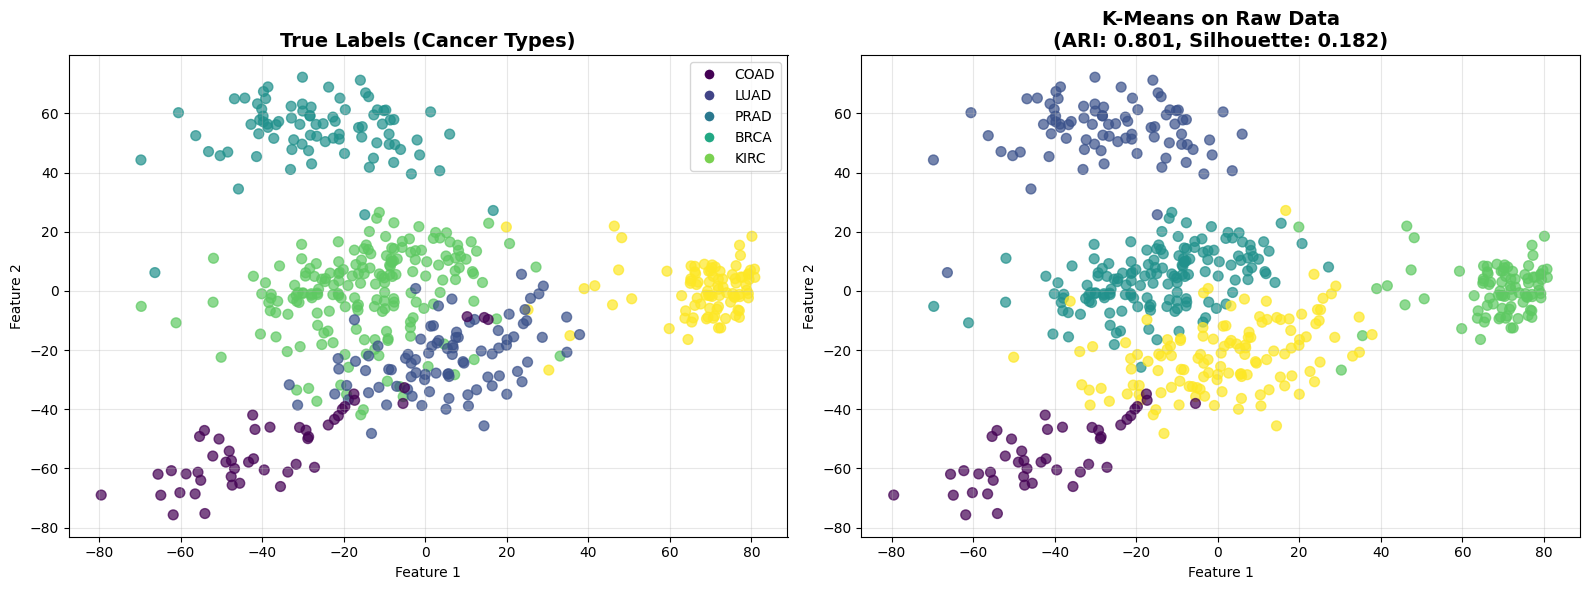

In [34]:
plot_2cluster_comparison(X_pca, y_true, labels_raw,
                            'True Labels (Cancer Types)', 
                            f'K-Means on Raw Data\n(ARI: {ari_raw:.3f}, Silhouette: {sil_raw:.3f})')

The results above show that K-Means on raw 10,000 features already provides good cancer type detection (ARI: 0.801, Silhouette: 0.182).

However, in high-dimensional spaces this performance isn't always guaranteed. A common strategy to improve clustering is:

• **Apply dimensionality reduction first** (PCA) then cluster on reduced components
• **Benefits:** Removes noise, reduces computation, improves distance interpretability
• **Typical approach:** Use first 5-10 components for clustering

Let's try this! We calculate the first 10 principal components and apply K-Means clustering on this reduced representation.

In [35]:
# Apply K-Means on PCA-reduced data
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca[:,:10])

# Evaluate clustering performance
ari_pca = adjusted_rand_score(y_true, labels_pca)
sil_pca = silhouette_score(X_pca, labels_pca)


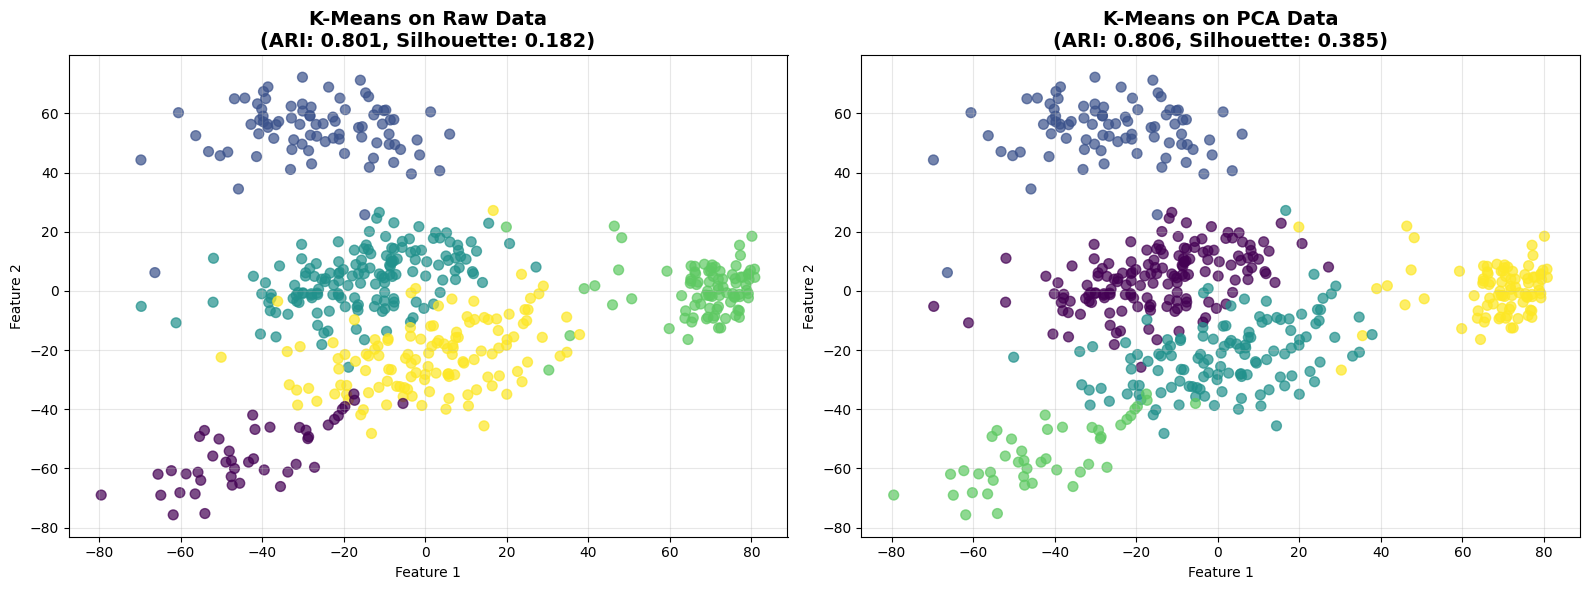

In [37]:
plot_2cluster_comparison(X_pca, labels_raw, labels_pca,
                            f'K-Means on Raw Data\n(ARI: {ari_raw:.3f}, Silhouette: {sil_raw:.3f})',
                            f'K-Means on PCA Data\n(ARI: {ari_pca:.3f}, Silhouette: {sil_pca:.3f})')

**Results:** Clustering on the first 10 PCA components shows minimal performance change (ARI: 0.806, Silhouette: 0.385), demonstrating that our clustering performs well even on the reduced dataset. This is excellent news for computational efficiency!

**Next steps:** Let's now systematically compare all clustering algorithms on both:
- **Raw dataset** (10,000 features)  
- **PCA-reduced dataset** (10 components)

This will give us a comprehensive view of how different algorithms perform across dimensionalities. (we maybe need to hide some code here)

Performance on Raw Data (10,000 features):
   K-Means        : ARI = 0.801, Silhouette = 0.182
   K-Medoids      : ARI = 0.919, Silhouette = 0.182
   Hierarchical (Ward): ARI = 0.825, Silhouette = 0.182
   DBSCAN         : ARI = 0.295, Silhouette = 0.148

Performance on PCA Data (10 components):
   K-Means        : ARI = 0.806, Silhouette = 0.385
   K-Medoids      : ARI = 0.863, Silhouette = 0.384
   Hierarchical (Ward): ARI = 0.810, Silhouette = 0.385
   DBSCAN         : ARI = 0.876, Silhouette = 0.429


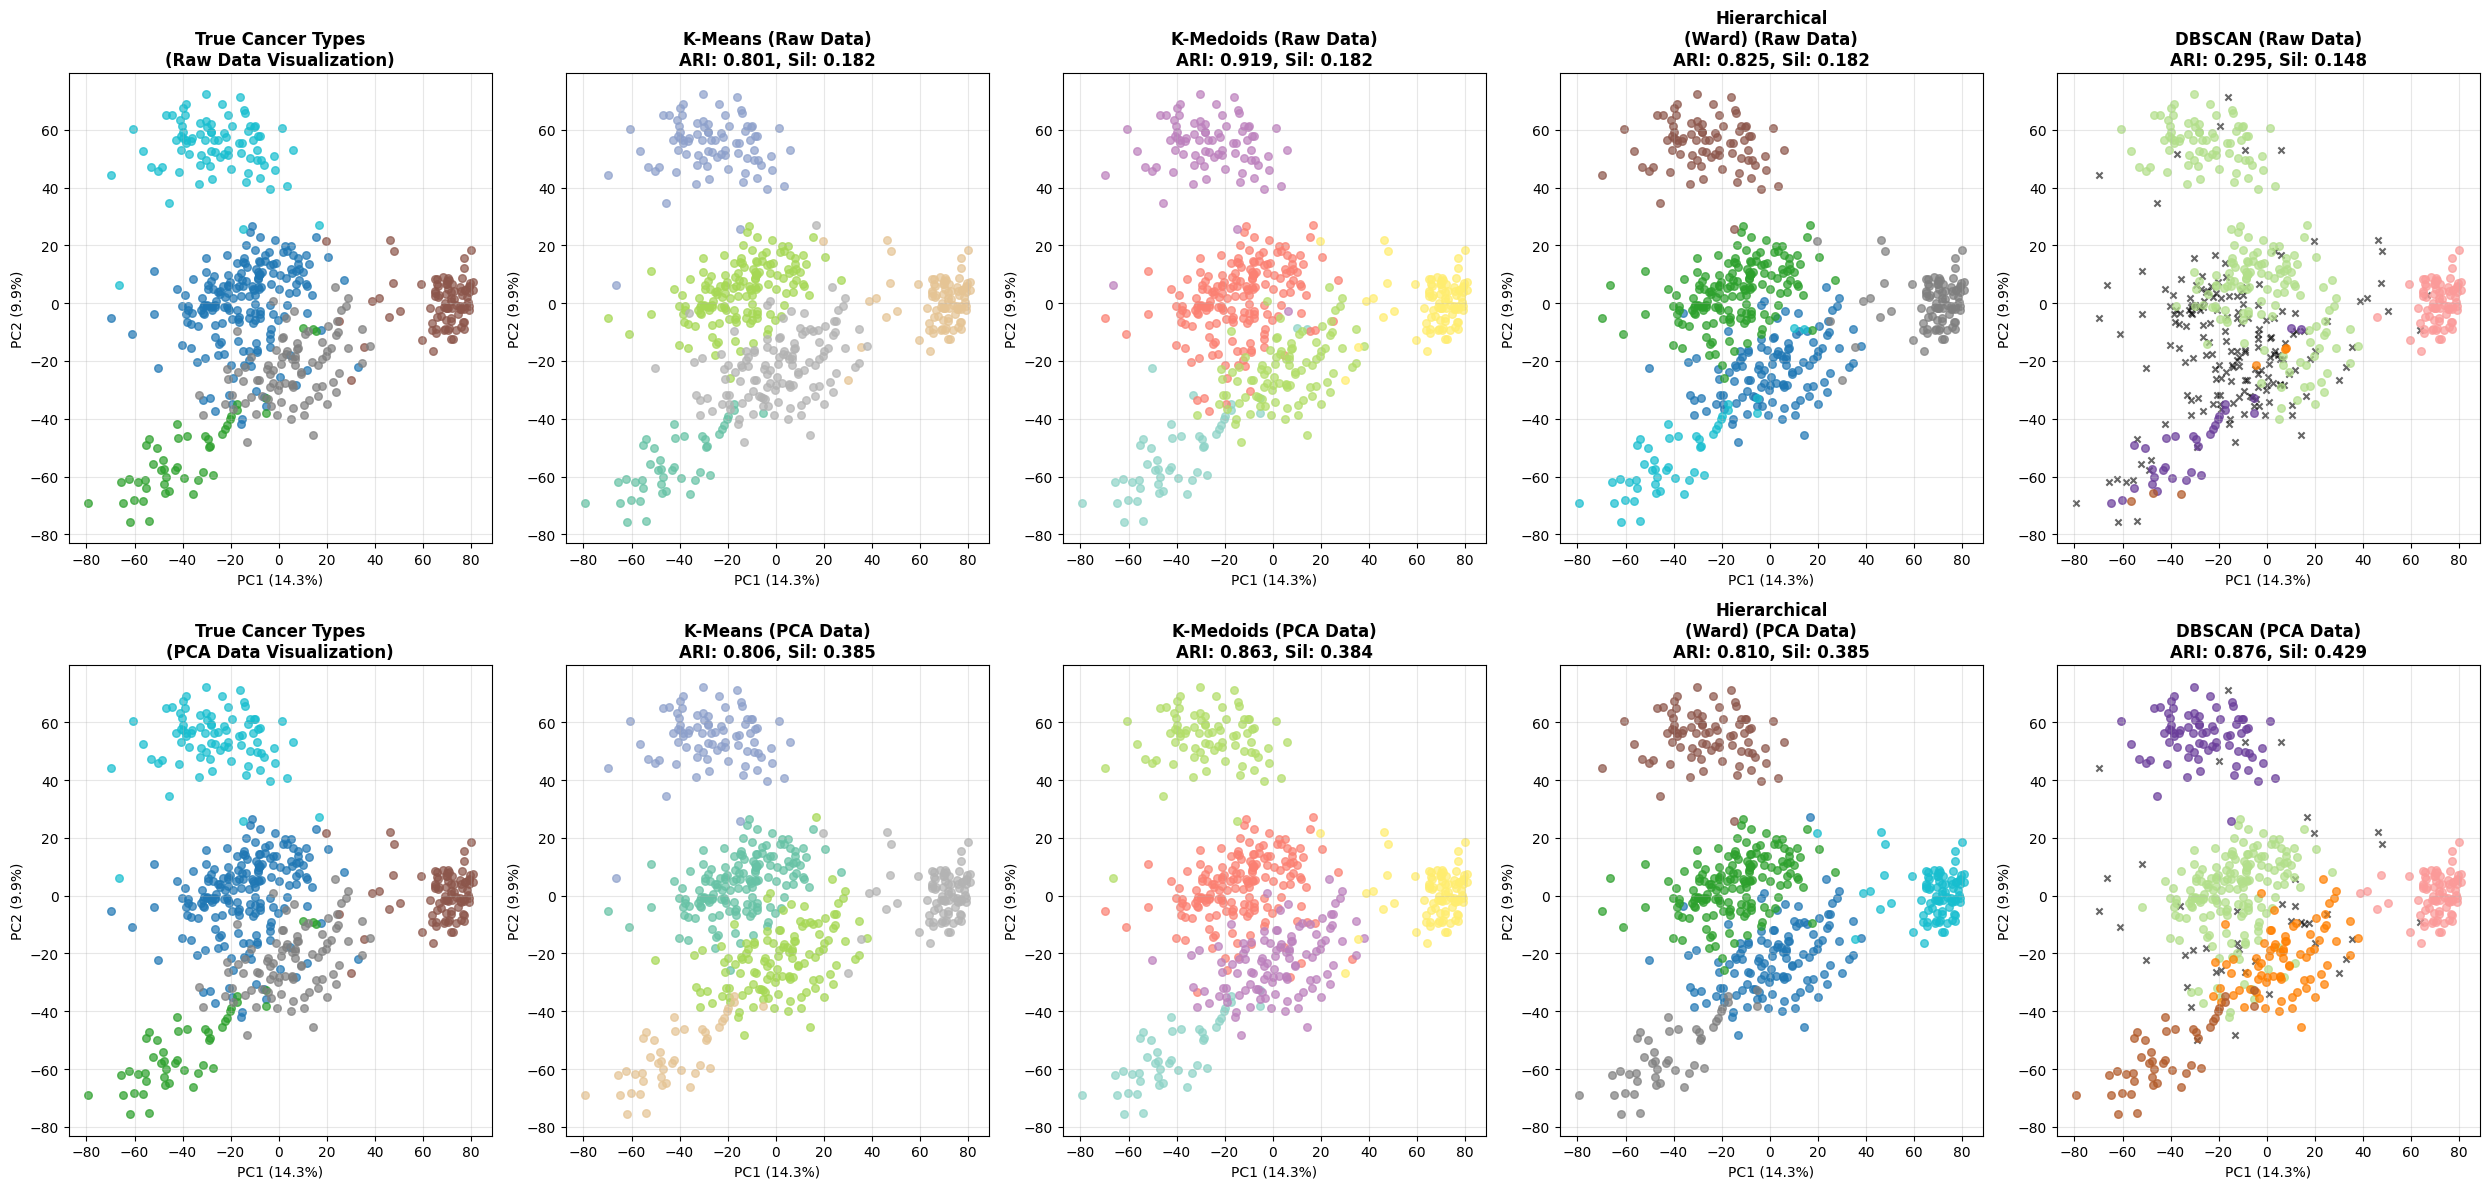

In [38]:
# Apply multiple clustering algorithms on both raw and PCA-reduced data

compare_all_Algorithms(X_raw_scaled, X_pca, y_true, pca, labels_pca)

## Results Interpretation

**Performance Comparison:**
- **K-Medoids** shows the highest ARI scores on both raw (0.919) and PCA data (0.863), indicating superior cancer type separation
- **Hierarchical clustering** performs consistently well across both feature spaces (ARI ~0.82-0.81)
- **K-Means** maintains stable performance with slight improvement on PCA data
- **DBSCAN** struggles with this dataset, likely due to the overlapping nature of cancer gene expression profiles

**Raw vs. PCA Performance:**
- Most algorithms show **comparable performance** on both feature spaces
- **DBSCAN benefits most** from PCA reduction (ARI: 0.295 → 0.876), suggesting dimensionality reduction helps with density-based clustering
- **Computational efficiency** gained with PCA (10 vs 10,000 features) without sacrificing accuracy

## Clinical Applications Overview

**K-Means/K-Medoids:**
- **Best for**: Patient stratification when you know the number of groups (e.g., risk categories)
- **Advantage**: Fast, scalable for large patient databases
- **Use case**: Creating risk groups, treatment cohorts, or diagnostic categories

**Hierarchical Clustering:**
- **Best for**: Understanding patient relationships and creating clinical decision trees
- **Advantage**: Visual dendrogram shows how patient groups relate to each other
- **Use case**: Identifying disease subtypes or treatment response patterns

**DBSCAN:**
- **Best for**: Discovering unknown patient subgroups and identifying outliers
- **Advantage**: Finds rare patient types and unusual cases automatically
- **Use case**: Detecting rare diseases, unusual treatment responses, or data quality issues

**Clinical Recommendation**: Start with hierarchical clustering for exploration, use K-means for known categories, apply DBSCAN for outlier detection.

---